In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import h5py
import os
import sys
import pickle
import tqdm
from scipy.stats import cumfreq

import matplotlib
from matplotlib import gridspec
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, LogLocator

import astropy.units as u
import astropy.constants as C
import peters
import wquantiles
import itertools
from tqdm import tqdm
from IPython.core.debugger import set_trace
from importlib import reload


colors = ['#377eb8', '#ff7f00', '#4daf4a',
                '#f781bf', '#a65628', '#984ea3',
                '#999999', '#e41a1c', '#dede00']


plt.style.use("/Users/michaelzevin/.MATPLOTLIB_RCPARAMS.sty")

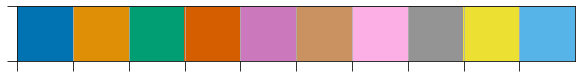

In [2]:
sns.palplot(sns.color_palette("colorblind"))

In [3]:
sys.path.append('/Users/michaelzevin/research/github/sgrb/')

from kickIT.galaxy_history import cosmology
from kickIT import convolve
cosmo = cosmology.Cosmology()

In [4]:
# Specify popsynth run and metallicity

popsynth_run = 'USSN_qc4_stableBBMT'
popsynth_met = 'Z1'

In [5]:
reload(convolve)

<module 'kickIT.convolve' from '/Users/michaelzevin/research/github/sgrb/kickIT/convolve.py'>

In [6]:
grbs = ['070809','090515']
runs=['sigma0','sigma1','sigma2','sigma-1','sigma-2']
data={}

popsynth_data = pd.read_csv(os.path.join('/Users/michaelzevin/research/sgrb/pop_models/production',popsynth_run,popsynth_met,'DNS_population.dat'), index_col=None)
Vsys = popsynth_data['Vsys']
Tinsp = popsynth_data['Tinsp']

bpath = '/Users/michaelzevin/research/sgrb/output_files/'
processed_data_name = 'tracers_processed_'+popsynth_run+'_'+popsynth_met


for grb in grbs:
    print(grb)
    data[grb] = {}
    
    for idx, run in enumerate(runs):
        print('  '+run)
        run_name = grb+'_'+run
        dirpath = os.path.join(bpath, grb, run_name)
        data[grb][run] = {}

        data[grb][run]['galaxy'] = pickle.load(open(os.path.join(dirpath, 'galaxy.pkl'), 'rb'))

        output_keys = list(h5py.File(os.path.join(dirpath, 'output.hdf'), 'r').keys())
        if processed_data_name in output_keys:
            # check to see if data has already been processed
            tracers = pd.read_hdf(os.path.join(dirpath, 'output.hdf'), key=processed_data_name)
            
        else:
            # calculate weights...this takes time
            tracers = pd.read_hdf(os.path.join(dirpath, 'output.hdf'), key='tracers')

            print("     Calculating popsynth weights...")
            tracers['popsynth_weight'] = convolve.weight_tracers_from_samples(tracers, Vsys, Tinsp)
            offset = data[grb][run]['galaxy'].obs_props['rad_offset'].value
            offset_error = data[grb][run]['galaxy'].obs_props['rad_offset_error'].value
            tracers['obs_weight'] = convolve.weight_tracers_from_observations(tracers, offset, offset_error, normalize=True)
            print("     Calculating observational weights...")
            tracers['combined_weight'] = convolve.combine_weights([tracers['obs_weight'], tracers['popsynth_weight']], combine_method='multiply')

            tracers.to_hdf(os.path.join(dirpath, 'output.hdf'), key=processed_data_name)

        data[grb][run]['tracers'] = tracers


070809
  sigma0
  sigma1
  sigma2
  sigma-1
  sigma-2
090515
  sigma0
  sigma1
  sigma2
  sigma-1
  sigma-2


In [7]:
lbl_dict = {'R_offset':r'$R_{\rm off}$ [kpc]', 'Rproj_offset':r'$R_{\rm off}$ [kpc]', 'R':'$R$ [kpc]', \
            'Vpost':r'$V_{\rm post}$ [km/s]', 'Vsys':r'$V_{\rm sys}$ [km/s]', 'Tinsp':r'$T_{\rm insp}$ [Myr]', 't0':r'$t_{\rm birth}$ [Gyr]',\
            'sigma0':r'$\sigma_{\rm DM}=0$',\
            'sigma1':r'$\sigma_{\rm DM}=1$',\
            'sigma2':r'$\sigma_{\rm DM}=2$',\
            'sigma-1':r'$\sigma_{\rm DM}=-1$',\
            'sigma-2':r'$\sigma_{\rm DM}=-2$',\
            'Vk': r'$V_{\rm k1}$ [km s$^{-1}$]', 'Vk': r'$V_{\rm k}$ [km s$^{-1}$]', 'Tinsp': r'$t_{\rm insp}$ [Myr]', 'Mpre': r'$M_{\rm pre}$ [M$_{\odot}$]',\
            'Vsys': r'$V_{\rm sys}$ [km s$^{-1}$]', 'a': r'$A_{\rm post}$ [R$_{\odot}$]',\
            '070809':'GRB070809', '090515':'GRB090515'}

sigma_dict = {'sigma-2': 2, 'sigma-1': 3, 'sigma0': 4, 'sigma1': 5, 'sigma2': 6}

### Galaxy evolution across time / dynamical history. Include different mass components/SFR as well as evolution of median offset of tracers

In [10]:
def plot_gal_history(gal):
    fig = plt.figure(figsize=(20,12))
    gs = gridspec.GridSpec(21,3)
    
    color_dict = {'stars':1, 'gas':2, 'dark matter':4, 'total':7}
    
    dens_axs = []
    for i in range(3):
        dens_axs.append(fig.add_subplot(gs[:7,i]))
    
    time_ax = fig.add_subplot(gs[12:,:])
    sfr_ax = time_ax.twinx()
    redz_ax = time_ax.twiny()

    ### Density plot
    # set scales
    for ax in dens_axs:
        ax.set_xscale('log')
        ax.set_yscale('log')
    # set limits
    for ax in dens_axs:
        ax.set_xlim(gal.rads[0].value,gal.rads[-1].value)
        ax.set_ylim(1e-6,1e4)
    # label axes
    for idx, ax in enumerate(dens_axs):
        ax.set_xlabel('$R$ [kpc]')
    # set ticks
    dens_axs[0].set_yticks([1e-6,1e-3,1e0,1e3])
    for ax in dens_axs:
        ax.set_xticks([1e-4,1e-2,1e0,1e2])
            
    # get rads (with 0 appended to front) and surface areas
    rads = gal.rads.insert(0, 0*u.kpc).to(u.pc)
    dS = np.pi * (rads[1:]**2 - rads[0:-1]**2)
    dV = 4./3 * np.pi * (rads[1:]**3 - rads[0:-1]**3)
            
    # plot the time-dependent density distributions 
    Nsteps = len(gal.times)
    for idx, (comp,scale,lbl) in enumerate(zip([gal.mass_stars_prof,gal.mass_gas_prof,gal.mass_dm_prof],\
                                               [gal.Rscale_baryons,gal.Rscale_baryons,gal.Rscale_dm],['stars','gas','dark matter'])):
        
        # plot the scale radii
        dens_axs[idx].axvline(scale[-1].value, color=colors[color_dict[lbl]], linestyle='--', lw=4)
        if lbl=='dark matter':
            dens_axs[idx].annotate(r'$R_{\rm s,\,DM}$', xy=(10, 1e-1), va='bottom', xycoords='data', rotation=90, fontsize=40)
        elif lbl=='stars':
            dens_axs[idx].annotate(r'$R_{\rm s,\,\star}$', xy=(0.5, 3e-6), va='bottom', xycoords='data', rotation=90, fontsize=40)
        elif lbl=='gas':
            dens_axs[idx].annotate(r'$R_{\rm s,\,gas}$', xy=(0.5, 3e-6), va='bottom', xycoords='data', rotation=90, fontsize=40)
        
        # plot title
        dens_axs[idx].set_title(lbl, fontsize=30)
            
        # normalize redshifts
        diff_redz = gal.obs_props['redz'] - gal.redz
        low,high = 0.05, 1
        normed_redz = (high-low) * (diff_redz - diff_redz.min())/(diff_redz.max() - diff_redz.min()) + low
        
        for zidx, z in enumerate(gal.redz):
            
            if lbl=='dark matter':
                dens_axs[idx].plot(gal.rads.value, (comp[zidx]/dV).value, color=colors[color_dict[lbl]], alpha=normed_redz[zidx])
                dens_axs[idx].set_ylabel(r'$\rho\,[\mathrm{M}_{\odot}\, \mathrm{pc}^{-3}$]')
            else:
                dens_axs[idx].plot(gal.rads.value, (comp[zidx]/dS).value, color=colors[color_dict[lbl]], alpha=normed_redz[zidx])
                dens_axs[idx].set_ylabel(r'$\Sigma\,[\mathrm{M}_{\odot}\, \mathrm{pc}^{-2}$]')
                
        
        # set ylims and ticks the same
        dens_axs[idx].set_ylim(1e-6, 1e4)
        dens_axs[idx].set_yticks([1e-6,1e-3,1e0,1e3])
        dens_axs[idx].set_yticklabels(['1e-6','1e-3','1e0','1e3'])
        
        # get rid of units
        if idx>0:
            dens_axs[idx].set_yticklabels([])
            
            
    ### Time plot
    # set scales
    time_ax.set_xscale('linear')
    time_ax.set_yscale('log')
    # set limits
    times = gal.times[-1]-gal.times
    time_ax.set_xlim(times[0].value,times[-1].value)
    time_ax.set_ylim(1e7,2e11)
    time_ax.set_yticks([1e7,1e8,1e9,1e10,1e11])
    time_ax.set_yticklabels(['1e7','1e8','1e9','1e10','1e11'])
    # label axes
    time_ax.set_xlabel(r'$t_{\rm GRB}-t$ [Gyr]')
    time_ax.set_ylabel(r'$M_{R<10\,\mathrm{kpc}}\,[\mathrm{M}_{\odot}]$')
    
    # plot sfr axis
    sfr_ax.set_ylabel(r'SFR $[\mathrm{M}_{\odot}\,{\rm yr}^{-1}]$', color='royalblue', labelpad=15)
    sfr_ax.set_yticks(np.arange(0,41,10))
    sfr_ax.scatter(times, gal.sfr, color='royalblue', alpha=0.6, zorder=-15)
    sfr_ax.grid(False)
    sfr_ax.set_ylim(0,40)
    
    # plot redshift axis
    redz_vals = np.arange(0.5, gal.redz[0], 0.5)[::-1]
    time_vals = cosmo.age(gal.obs_props['redz']) - cosmo.age(redz_vals)
    
    redz_ax.set_xlim(times[0].value,times[-1].value)
    redz_ax.plot(times, np.zeros_like(times))
    redz_ax.set_xlabel('$z$')
    redz_ax.grid(False)
    redz_ax.set_xticks(time_vals.value)
    redz_ax.set_xticklabels(redz_vals)
    
    
    # plot observed parameters
    t_sfr = (gal.times[-1]-gal.time_sfr_peak).value
    t_quench = (gal.times[-1]-gal.time_quench).value
    time_ax.axvline(t_sfr, color=colors[7], lw=3, ls='--', alpha=0.5)
    time_ax.axvline(t_quench, color=colors[7], lw=3, ls='--', alpha=0.5)
    time_ax.annotate(r'$t_{\rm SFR,\ peak}$', xy=(t_sfr+0.17, 2e7), xycoords='data', va='bottom', rotation=90, fontsize=40)
    time_ax.annotate(r'$t_{\rm quench}$', xy=(t_quench+0.17, 2e7), xycoords='data', va='bottom', rotation=90, fontsize=40)
    
    for idx, (comp,lbl,ls) in enumerate(zip([gal.mass_stars_prof,gal.mass_gas_prof,gal.mass_dm_prof, (gal.mass_stars_prof+gal.mass_gas_prof+gal.mass_dm_prof)],\
                                               ['stars','gas','dark matter','total'], ['--','-.',':','-'])):
        
        for ridx, (rad_lim, lw, alpha) in enumerate(zip(np.asarray([10])*u.kpc, [5], [0.7])):
                    
            rad_idxs = np.argwhere(gal.rads <= rad_lim).flatten()
            Menc = np.sum(comp[:,rad_idxs], axis=1)
            
        
            if ridx!=0:
                lbl=None
            
            time_ax.plot(times, Menc, color=colors[color_dict[lbl]], label=lbl, lw=lw, ls=ls, alpha=alpha)
                
                
    # rearrange legend
    handles, labels = time_ax.get_legend_handles_labels()
    labels = [labels[3], labels[2], labels[0], labels[1]]
    handles = [handles[3], handles[2], handles[0], handles[1]]
    time_ax.legend(handles, labels, loc='lower right', prop={'size':25})
    
    
    
    # annotate upper plots
    for idx, ax in enumerate(dens_axs):
        if idx==0:
            ax.annotate('formation', xy=(5e-2, 4e-6), xytext=(1.5e-4, 2e-6), xycoords='data', arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)
            ax.annotate('explosion', xy=(1e-1, 2e3), xytext=(1.5e-4, 8e1), xycoords='data', arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)
        if idx==1:
            ax.annotate('formation', xy=(1e-2, 5e1), xytext=(1.5e-4, 1e0), xycoords='data', arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)
            ax.annotate('explosion', xy=(5e-2, 3e2), xytext=(1.5e-4, 1e3), xycoords='data', arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)
        if idx==2:
            ax.annotate('formation', xy=(1e-2, 6e0), xytext=(1.5e-4, 1e-1), xycoords='data', arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)
            ax.annotate('explosion', xy=(5e-2, 5e0), xytext=(1.5e-4, 1.8e3), xycoords='data', arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)
    
    
            
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.savefig('/Users/michaelzevin/research/sgrb/paper_files/figures/galaxy_model.png', dpi=200)
    plt.savefig('/Users/michaelzevin/research/sgrb/paper_files/figures/galaxy_model.pdf', dpi=200)
    

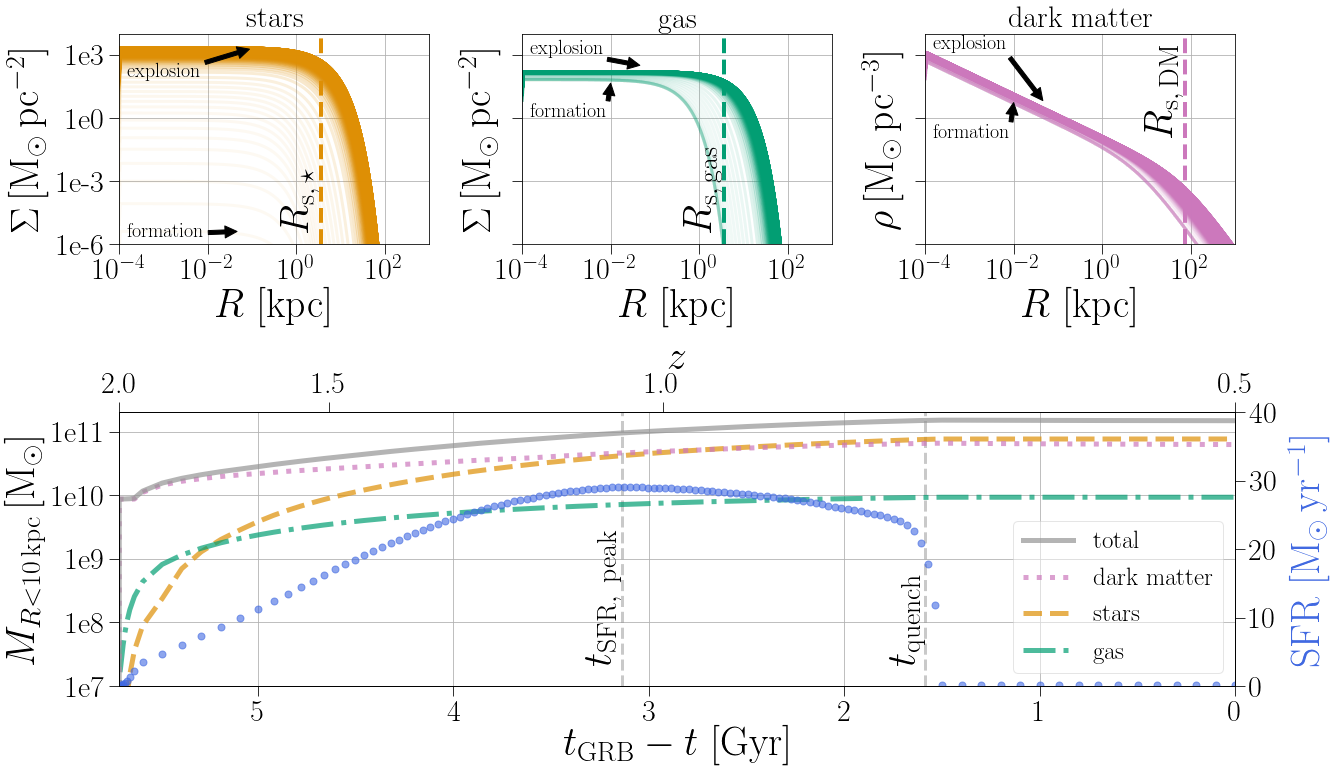

In [11]:
colors = sns.color_palette("colorblind")

gal = data['070809']['sigma0']['galaxy']
    
plot_gal_history(gal)

### Contour plot of sGRB offsets, weighted by the population model

In [10]:
# get trajectories that match the projected offset, a bit hacky since we 

grb = '070809'
grb_data = data[grb]['sigma0']
tracers = grb_data['tracers']

gal = grb_data['galaxy']
Roff=gal.obs_props['rad_offset']
Roff_error=gal.obs_props['rad_offset_error']

traj = pd.read_hdf('/Users/michaelzevin/research/sgrb/output_files/'+grb+'/'+grb+'_sigma0_timesteps/output.hdf', key='trajectories')
traj['index'] = traj.index
traj_last = traj.groupby('index').last()

matching_idxs = traj_last.loc[(traj_last['R_offset'] > (Roff-Roff_error).value) & (traj_last['R_offset'] < (Roff+Roff_error).value) & \
                 (np.abs(traj_last['Z']) < 1)].index
cut_traj = traj.loc[matching_idxs]

In [245]:
# add new linestyles

from collections import OrderedDict

linestyles = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])

def plot_spatial_density(grb, data, traj=None, method=1, thresholds=[90], Nbins=1000, maxD=100, weighting=None, plot_traj=None):

    if plot_traj is not None:
        fig, axs = plt.subplots(1,1, figsize=(12,9))
    else:
        fig, axs = plt.subplots(1,1, figsize=(9,9))
        
    # plot limits
    axs.set_xlim(-maxD,maxD)
    axs.set_ylim(-maxD,maxD)
    
    # labels
    axs.set_xlabel('$x$ [kpc]', fontsize=35)
    axs.set_ylabel('$y$ [kpc]', fontsize=35)
    
    # ticks
    axs.set_xticks([-80,-40,0,40,80])
    axs.set_yticks([-80,-40,0,40,80])
    
    # store Rbounds for contours
    Rbounds=[]
    
    for idx, (sigma,ls,alpha,lw) in enumerate(zip(['-2','-1','0','1','2'],\
                                             ['solid','densely dashed','densely dashdotted','densely dashdotdotted','densely dotted'],\
                                             [0.5, 0.5, 0.5, 0.5, 0.5],\
                                                 [2,3,4,3,2])):
        
        grb_data = data[grb]['sigma'+sigma]
        tracers = grb_data['tracers']
        gal = grb_data['galaxy']
            
        # plot the projected offset of the grb
        if idx==0:
            thetas = np.linspace(0,2*np.pi, 1000)
            Roff = gal.obs_props['rad_offset'].value
            Roff_err = gal.obs_props['rad_offset_error'].value
            axs.plot(Roff*np.cos(thetas), Roff*np.sin(thetas), color=colors[3], lw=6, linestyle='--')
            
            xs = np.outer([Roff-Roff_err,Roff+Roff_err], np.cos(thetas))
            ys = np.outer([Roff-Roff_err,Roff+Roff_err], np.sin(thetas))

            # in order to have a closed area, the circles should be traversed in opposite directions
            xs[1,:] = xs[1,::-1]
            ys[1,:] = ys[1,::-1]

            axs.fill(np.ravel(xs), np.ravel(ys), color=colors[3], alpha=0.5, zorder=-5)

    
        x = tracers['X']
        y = tracers['Y']
        z = tracers['Z']
        R = np.sqrt(x**2 + y**2 + z**2)

        # use weights if this argument is given
        if weighting is None:
            weights = np.ones(len(x))
        else:
            weights = np.asarray(tracers[weighting])

    
        if method==1:
            # Method 1, just use the radii
            
            randvar = np.random.random(size=len(weights))
            hold = np.argwhere(weights >= randvar).flatten()
            Rsort = np.sort(R.iloc[hold].values)

            # draw circles at the proper radii
            for t in thresholds[::-1]:
                Rbound = Rsort[int(len(Rsort)*t/100.)]
                print(Rbound)
                Rbounds.append(Rbound)
                axs.plot(Rbound*np.cos(thetas), Rbound*np.sin(thetas), color=colors[0], lw=lw, linestyle=linestyles[ls], alpha=alpha, \
                         zorder=10, label=r'$\sigma_{\rm DM}=$ '+str(sigma))
                
            # downsample for scatterplot
            scat_idxs = np.random.choice(np.arange(len(hold)), 2000)
            axs.scatter(x[scat_idxs], y[scat_idxs], color=colors[7], s=20, marker='.', alpha=0.5, rasterized=True, zorder=3)
            

        else:
            # bin the data up in a 2D histogram
            heights, xbins, ybins = np.histogram2d(x, y, bins=(Nbins,Nbins), weights=weights, \
                                                   range=((-maxD,maxD),(-maxD,maxD)), normed=True)

            # calculate the volume element for each bin
            # NOTE: this is only really necessary if the bins are not equal sizes, e.g. logspace
            dx, dy = xbins[1:] - xbins[:-1], ybins[1:] - ybins[:-1]
            bin_dims = np.asarray(list(itertools.product(dx,dy)))
            dv = np.multiply(bin_dims[:,0], bin_dims[:,1]).reshape((Nbins,Nbins))
            dv = dv.flatten()

            # determine the indices of the bins, decreasing in height
            heights = heights.flatten()
            hsort = heights.argsort()[::-1]

            # get threshold values
            thresh=[]
            for t in thresholds[::-1]:
                hist_idx = np.argwhere(heights[hsort].cumsum() * dv[hsort] > t/100.)[0][0]
                thresh_val = heights[hsort][hist_idx]
                thresh.append(thresh_val)


            ### Plot contours and scatterplot
            axs.scatter(x, y, c=np.log10(weights), cmap='viridis', s=3, marker='.', alpha=0.05, rasterized=True)

            if method==2:
                # Method 2: Use matplotlib's contour
                # plot using matplotlib's contour
                xbins_cent = xbins[1:] + (xbins[1:]-xbins[:-1])/2.0
                ybins_cent = ybins[1:] + (ybins[1:]-ybins[:-1])/2.0
                axs.contour(xbins_cent, ybins_cent, heights.reshape(xbins_cent.shape[0], ybins_cent.shape[0]), \
                            levels=thresh, colors='green', linewidths=np.linspace(1,3,len(thresholds)))

            elif method==3:
                # Method 3: use seaborn's kdeplot
                # plot using seaborn's kdeplot, which smooths things out with KDEs
                sns.kdeplot(x, y, ax=axs, levels=thresh, colors='green', shade=False, alpha=0.7, \
                            clip=((-maxD,maxD),(-maxD,maxD)), linewidths=np.linspace(1,3,len(thresholds)))
    


    print(Rbounds)
    for (pair,alpha) in zip([[Rbounds[0],Rbounds[1]],[Rbounds[1],Rbounds[2]],[Rbounds[2],Rbounds[3]],[Rbounds[3],Rbounds[4]],[Rbounds[4],0]], \
                           [0.1,0.2,0.3,0.4,0.5]):
        xs = np.outer([pair[0],pair[1]], np.cos(thetas))
        ys = np.outer([pair[0],pair[1]], np.sin(thetas))

        # in order to have a closed area, the circles should be traversed in opposite directions
        xs[1,:] = xs[1,::-1]
        ys[1,:] = ys[1,::-1]

        axs.fill(np.ravel(xs), np.ravel(ys), color=colors[0], alpha=alpha, zorder=-10)

    
    # plot some trajectories, if specified
    if plot_traj is not None:
        grb_data = data[grb]['sigma0']
        gal = grb_data['galaxy']
        tracers = grb_data['tracers']
        trac_cut = tracers.loc[traj.index.unique()]
        
        # select trajectories to plot based on their popsynth weights
        weights = trac_cut['popsynth_weight']/np.sum(trac_cut['popsynth_weight'])
        if plot_traj > 0:
            plot_idxs = [plot_traj]
        else:
            plot_idxs = np.random.choice(trac_cut.index, 1, p=weights)
        print(plot_idxs)

        cmap = plt.cm.inferno_r
        for idx in plot_idxs:
            tmp_traj = traj.loc[idx]
            
            # see about how far it traveled
            x_dist2 = (tmp_traj[1:]['X']-tmp_traj[:-1]['X'])**2
            y_dist2 = (tmp_traj[1:]['Y']-tmp_traj[:-1]['Y'])**2
            z_dist2 = (tmp_traj[1:]['Z']-tmp_traj[:-1]['Z'])**2
            dist = np.sum(np.sqrt(x_dist2+y_dist2+z_dist2))
            print(dist, tracers.loc[idx]['Vsys'])
            
            axs.scatter(tmp_traj['X'].iloc[-1], tmp_traj['Y'].iloc[-1], color='k', alpha=1.0, s=500, marker='*', zorder=20)
            axs.scatter(tmp_traj['X'].iloc[0], tmp_traj['Y'].iloc[0], color='g', alpha=1.0, s=400, marker='X', zorder=20)
            
            Nlines = 100
            discrete_times = np.linspace(tmp_traj['time'].iloc[0], tmp_traj['time'].iloc[-1], Nlines+1)
            maxt=9
            mint=3
            for tidx in range(Nlines):
                tmp_traj_cut = tmp_traj.loc[(tmp_traj['time'] >= discrete_times[tidx])]
                cidx = 1.0 - (discrete_times[tidx]-mint)/(maxt-mint)
                axs.plot(tmp_traj_cut['X'], tmp_traj_cut['Y'], c=cmap(cidx), zorder=15, lw=4)
            
            
        # add colorbar
        t_vals = np.linspace(0, gal.time_dur.value, 1000)
        t_vals = np.linspace(0, maxt-mint, 1000)
        pts = axs.scatter(-1000*np.ones(1000), -1000*np.ones(1000), c=t_vals, cmap=cmap, vmin=t_vals[0], vmax=t_vals[-1])
        
        cbar = fig.colorbar(pts, ax=axs)
        cbar.set_label(r'$t_{\rm GRB}-t$ [Gyr]', fontsize=35)
        
    handles, labels = axs.get_legend_handles_labels()
    axs.legend(handles=handles[:5], labels=labels[:5], loc='lower right', prop={'size':25})
    plt.tight_layout()
    plt.savefig('/Users/michaelzevin/research/sgrb/paper_files/figures/kinematic.png', dpi=200)
    plt.savefig('/Users/michaelzevin/research/sgrb/paper_files/figures/kinematic.pdf', dpi=200)

### PLOT FOR PROPOSAL!

In [23]:
# add new linestyles

from collections import OrderedDict

linestyles = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])

def plot_spatial_density_proposal(grb, data, traj=None, method=1, thresholds=[90], Nbins=1000, maxD=100, weighting=None, plot_traj=None):

    if plot_traj is not None:
        fig, axs = plt.subplots(1,1, figsize=(12,9))
    else:
        fig, axs = plt.subplots(1,1, figsize=(9,9))
        
    # plot limits
    axs.set_xlim(-maxD,maxD)
    axs.set_ylim(-maxD,maxD)
    
    # labels
    axs.set_xlabel('$x$ [kpc]', fontsize=35)
    axs.set_ylabel('$y$ [kpc]', fontsize=35)
    
    # ticks
    axs.set_xticks([-80,-40,0,40,80])
    axs.set_yticks([-80,-40,0,40,80])
    
    # store Rbounds for contours
    Rbounds=[]
    
    for idx, (sigma,ls,alpha,lw) in enumerate(zip(['-2','-1','0','1','2'],\
                                             ['solid','densely dashed','densely dashdotted','densely dashdotdotted','densely dotted'],\
                                             [0.5, 0.5, 0.5, 0.5, 0.5],\
                                                 [2,3,4,3,2])):
        
        #grb_data = data[grb]['sigma'+sigma+'_prospector']
        grb_data = data[grb]['sigma'+sigma]
        tracers = grb_data['tracers']
        gal = grb_data['galaxy']
            
        # plot the projected offset of the grb
        if idx==0:
            thetas = np.linspace(0,2*np.pi, 1000)
            Roff = gal.obs_props['rad_offset'].value
            Roff_err = gal.obs_props['rad_offset_error'].value
            axs.plot(Roff*np.cos(thetas), Roff*np.sin(thetas), color=colors[3], lw=6, linestyle='--')
            
            xs = np.outer([Roff-Roff_err,Roff+Roff_err], np.cos(thetas))
            ys = np.outer([Roff-Roff_err,Roff+Roff_err], np.sin(thetas))

            # in order to have a closed area, the circles should be traversed in opposite directions
            xs[1,:] = xs[1,::-1]
            ys[1,:] = ys[1,::-1]

            axs.fill(np.ravel(xs), np.ravel(ys), color=colors[3], alpha=0.5, zorder=-5)

    
        x = tracers['X']
        y = tracers['Y']
        z = tracers['Z']
        R = np.sqrt(x**2 + y**2 + z**2)

        # use weights if this argument is given
        if weighting is None:
            weights = np.ones(len(x))
        else:
            weights = np.asarray(tracers[weighting])

    
        if method==1:
            # Method 1, just use the radii
            
            randvar = np.random.random(size=len(weights))    
            hold = np.argwhere(weights >= randvar).flatten()
            Rsort = np.sort(R.iloc[hold].values)

            # draw circles at the proper radii
            for t in thresholds[::-1]:
                Rbound = Rsort[int(len(Rsort)*t/100.)]
                print(Rbound)
                Rbounds.append(Rbound)
                #axs.plot(Rbound*np.cos(thetas), Rbound*np.sin(thetas), color=colors[0], lw=lw, linestyle=linestyles[ls], alpha=alpha, \
                #         zorder=10, label=r'$\sigma_{\rm DM}=$ '+str(sigma))
            axs.scatter(x[hold], y[hold], color=colors[7], s=20, marker='.', alpha=0.5, rasterized=True)
            
            # annotate sigma DMs'
            #if sigma=='2':
            #    axs.annotate(r'$\sigma_{\rm DM}=%s$' % sigma, xy=(0,Rbound-9), xycoords='data', ha='center', fontsize=15)
            #else:
            #    axs.annotate(r'$\sigma_{\rm DM}=%s$' % sigma, xy=(0,Rbound+2), xycoords='data', ha='center', fontsize=15)
            

        else:
            # bin the data up in a 2D histogram
            heights, xbins, ybins = np.histogram2d(x, y, bins=(Nbins,Nbins), weights=weights, \
                                                   range=((-maxD,maxD),(-maxD,maxD)), normed=True)

            # calculate the volume element for each bin
            # NOTE: this is only really necessary if the bins are not equal sizes, e.g. logspace
            dx, dy = xbins[1:] - xbins[:-1], ybins[1:] - ybins[:-1]
            bin_dims = np.asarray(list(itertools.product(dx,dy)))
            dv = np.multiply(bin_dims[:,0], bin_dims[:,1]).reshape((Nbins,Nbins))
            dv = dv.flatten()

            # determine the indices of the bins, decreasing in height
            heights = heights.flatten()
            hsort = heights.argsort()[::-1]

            # get threshold values
            thresh=[]
            for t in thresholds[::-1]:
                hist_idx = np.argwhere(heights[hsort].cumsum() * dv[hsort] > t/100.)[0][0]
                thresh_val = heights[hsort][hist_idx]
                thresh.append(thresh_val)


            ### Plot contours and scatterplot
            axs.scatter(x, y, c=np.log10(weights), cmap='viridis', s=3, marker='.', alpha=0.05, rasterized=True)

            if method==2:
                # Method 2: Use matplotlib's contour
                # plot using matplotlib's contour
                xbins_cent = xbins[1:] + (xbins[1:]-xbins[:-1])/2.0
                ybins_cent = ybins[1:] + (ybins[1:]-ybins[:-1])/2.0
                axs.contour(xbins_cent, ybins_cent, heights.reshape(xbins_cent.shape[0], ybins_cent.shape[0]), \
                            levels=thresh, colors='green', linewidths=np.linspace(1,3,len(thresholds)))

            elif method==3:
                # Method 3: use seaborn's kdeplot
                # plot using seaborn's kdeplot, which smooths things out with KDEs
                sns.kdeplot(x, y, ax=axs, levels=thresh, colors='green', shade=False, alpha=0.7, \
                            clip=((-maxD,maxD),(-maxD,maxD)), linewidths=np.linspace(1,3,len(thresholds)))
    


    print(Rbounds)
    for (pair,alpha) in zip([[Rbounds[0],Rbounds[1]],[Rbounds[1],Rbounds[2]],[Rbounds[2],Rbounds[3]],[Rbounds[3],Rbounds[4]],[Rbounds[4],0]], \
                           [0.1,0.3,0.5,0.6,0.7]):
        xs = np.outer([pair[0],pair[1]], np.cos(thetas))
        ys = np.outer([pair[0],pair[1]], np.sin(thetas))

        # in order to have a closed area, the circles should be traversed in opposite directions
        xs[1,:] = xs[1,::-1]
        ys[1,:] = ys[1,::-1]

        #axs.fill(np.ravel(xs), np.ravel(ys), color=colors[0], alpha=alpha, zorder=-10)

    
    # plot some trajectories, if specified
    if plot_traj is not None:
        #grb_data = data[grb]['sigma0_prospector']
        grb_data = data[grb]['sigma0']
        gal = grb_data['galaxy']
        tracers = grb_data['tracers']
        trac_cut = tracers.loc[traj.index.unique()]
        
        # select trajectories to plot based on their popsynth weights
        weights = trac_cut['popsynth_weight']/np.sum(trac_cut['popsynth_weight'])
        if  plot_traj > 0:
            plot_idxs = [plot_traj]
        else:
            plot_idxs = np.random.choice(trac_cut.index, 1, p=weights)
        print(plot_idxs)

        cmap = plt.cm.inferno_r
        for idx in plot_idxs:
            tmp_traj = traj.loc[idx]
            
            # see about how far it traveled
            x_dist2 = (tmp_traj[1:]['X']-tmp_traj[:-1]['X'])**2
            y_dist2 = (tmp_traj[1:]['Y']-tmp_traj[:-1]['Y'])**2
            z_dist2 = (tmp_traj[1:]['Z']-tmp_traj[:-1]['Z'])**2
            dist = np.sum(np.sqrt(x_dist2+y_dist2+z_dist2))
            print(dist, tracers.loc[idx]['Vsys'])
            
            axs.scatter(tmp_traj['X'].iloc[-1], tmp_traj['Y'].iloc[-1], color='k', alpha=1.0, s=500, marker='*', zorder=5)
            axs.annotate(r'$\textbf{merger}$', xy=(tmp_traj['X'].iloc[-1]-4, tmp_traj['Y'].iloc[-1]+2), \
                         xytext=(-80,50), xycoords='data', arrowprops=dict(facecolor='k'), fontsize=30, color='k')
            
            axs.scatter(tmp_traj['X'].iloc[0], tmp_traj['Y'].iloc[0], color='g', alpha=1.0, s=400, marker='X', zorder=5)
            axs.annotate(r'$\textbf{supernova}$', xy=(4,-4), \
                         xytext=(10,-60), xycoords='data', arrowprops=dict(facecolor='g'), fontsize=30, color='g')
            
            # fake a pre-SN orbit
            #R = np.sqrt((tmp_traj['X'].iloc[0])**2 + (tmp_traj['Y'].iloc[0])**2)
            #thetas = np.linspace(0,2*np.pi, 100)
            #phi = np.pi/2
            #axs.plot(R*np.cos(thetas), R*np.sin(thetas), color='g', zorder=5, lw=4)

            Nlines = 10
            discrete_times = np.linspace(tmp_traj['time'].iloc[0], tmp_traj['time'].iloc[-1], Nlines+1)
            for tidx in range(Nlines):
                tmp_traj_cut = tmp_traj.loc[(tmp_traj['time'] >= discrete_times[tidx])]
                cidx = (gal.time_end.value-discrete_times[tidx])/5
                axs.plot(tmp_traj_cut['X'], tmp_traj_cut['Y'], c=cmap(cidx), zorder=3, lw=4)
            #axs.plot(tmp_traj['X'], tmp_traj['Y'])

            
            
    
        # add colorbar
        #t_vals = np.linspace(0, gal.time_dur.value, 1000)
        t_vals = np.linspace(0, 5, 1000)
        pts = axs.scatter(-1000*np.ones(1000), -1000*np.ones(1000), c=t_vals, cmap=cmap, vmin=t_vals[0], vmax=t_vals[-1])
        
        cbar = fig.colorbar(pts, ax=axs)
        cbar.set_label(r'Time until GRB [Gyr]', fontsize=35)
        cax = cbar.ax
        cax.set_ylim(t_vals[-1], t_vals[0])
        
    #axs.legend(loc='lower right', prop={'size':25})
    #plt.savefig('/Users/michaelzevin/research/sgrb/paper_files/figures/kinematic.png')
    #plt.savefig('/Users/michaelzevin/research/sgrb/paper_files/figures/kinematic.pdf', dpi=200)
    #axs.set_title(r'$\mathrm{GRB}~070809$', fontsize=45)
    axs.annotate(r'$\textbf{GRB offset}$', xy=(3,33), xytext=(25,60), xycoords='data', \
                 arrowprops=dict(facecolor=colors[3]), fontsize=30, color=colors[3])
    
    plt.tight_layout()
    #plt.savefig('/Users/michaelzevin/Documents/Postdoc/kinematic.png', dpi=150)

56.28800919308636
48.05501241779615
37.238399569752346
29.905845379163896
25.646095675661424
[56.28800919308636, 48.05501241779615, 37.238399569752346, 29.905845379163896, 25.646095675661424]
[85811]
894.6923798018892 134.5022182139206


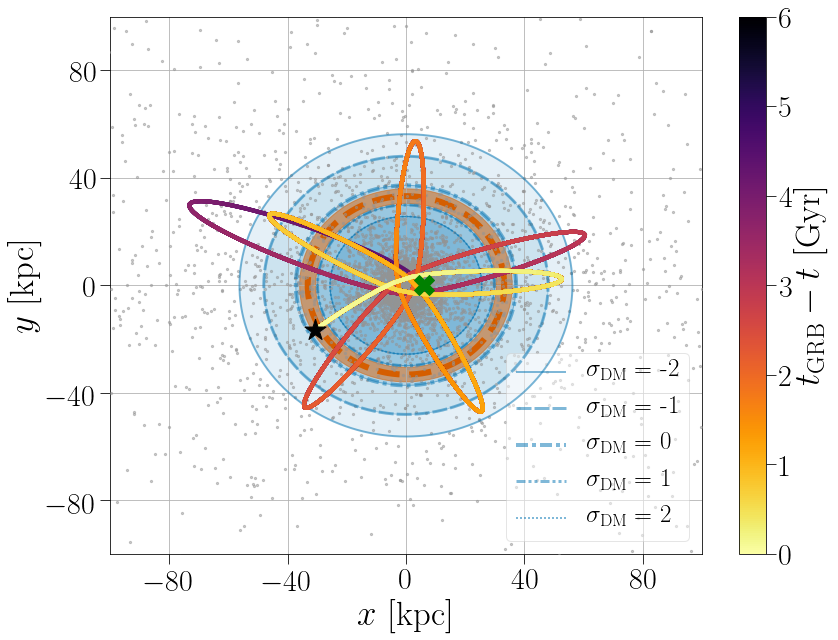

In [246]:
colors = sns.color_palette("colorblind")

plot_spatial_density('070809', data, cut_traj, method=1, thresholds=[95], maxD=100, weighting='popsynth_weight', plot_traj=85811)

In [14]:
# Nice looking indices: 15713, 13390, 45906, 71173, 85811

### Weighted PDFs and CDFs for different output parameters

In [433]:
def plot_weighted_cdf(grbs, param, limits, lbl_dict, logx=False, logcdf=False, marginalize=False, credible=False, \
                      weighting=None, cdf_min=None, Nbins=None):
    f, axs = plt.subplots(1, len(grbs), figsize=(25,10))
    
    for gidx, grb in enumerate(grbs.keys()):
        ax = axs[gidx]
        data = grbs[grb]
        
        twinax = ax.twiny()

        Nsys = len(data[next(iter(data))]['tracers'])
        
        # get bins
        if not Nbins:
            Nbins = int(np.sqrt(Nsys))
            
        # find range of parameters
        maxval=0
        minval=1e6
        for sig in [-2,-1,0,1,2]:
            tracers = data['sigma'+(str(int(sig)))]['tracers']
            # get rid of values where minimum is zero
            tracers = tracers.loc[tracers[param]>0]
            if tracers[param].max() > maxval:
                maxval = tracers[param].max() 
            if tracers[param].min() < minval:
                minval = tracers[param].min()
        if maxval > 1e6:
            maxval = 1e6
        if minval < 1e-2:
            minval = 1e-2
                        
        if logx==True:
            bins = np.logspace(np.log10(minval), np.log10(maxval), Nbins)
        else:
            bins = np.linspace(minval, maxval, Nbins)
            

        # label plots and axes scaling
        if logx==True:
            ax.set_xscale('log')

        ax.set_xlabel(r'$R$ [kpc]')
        if logcdf==True:
            if gidx==0:
                ax.set_ylabel(r'$f(R_{\rm off} > R)$')
            ax.set_yscale('log')
        else:
            if gidx==0:
                ax.set_ylabel(r'$cdf$')
                
                
            
        # plot the offset info
        for idx, run in enumerate(data):
            
            # mark the actual offset if this is the parameter
            if (idx==0) and ((param=='R_offset') or (param=='Rproj_offset')):
                galaxy = data[run]['galaxy']
                rad_eff = galaxy.obs_props['rad_eff'].value
                rad_offset = galaxy.obs_props['rad_offset'].value
                rad_offset_error = galaxy.obs_props['rad_offset_error'].value

                ax.axvline(rad_eff, color='k', linestyle=':', lw=4, zorder=20)
                ax.axvline(rad_offset, color='k', linestyle='--', lw=4, zorder=20)
                ax.axvspan((rad_offset - rad_offset_error), (rad_offset + rad_offset_error), color='k', alpha=0.5, zorder=20)
                    
        
        
        if credible==True:
            # plot the credible region for the sigma=0 run
            tracers = data['sigma0']['tracers']

            for scheme in weighting:
                if scheme=='prior':
                    continue
                else:
                    weights = tracers[scheme]
                    weights = weights/np.sum(weights)

                
            low50 = wquantiles.quantile(tracers[param], weights, 0.25)
            high50 = wquantiles.quantile(tracers[param], weights, 0.75)
            low90 = wquantiles.quantile(tracers[param], weights, 0.05)
            high90 = wquantiles.quantile(tracers[param], weights, 0.95)
            ax.axvspan(low50, high50, color='gray', alpha=0.4)
            ax.axvspan(low90, high90, color='gray', alpha=0.3)
            
            if grb=='070809':
                #print(low50/3.59,high50/3.59)
                #print(low90/3.59,high90/3.59)
                print(wquantiles.quantile(tracers[param]/3.59, weights, 0.9))
            else:
                #print(low50/4.42,high50/4.42)
                #print(low90/4.42,high90/4.42)
                print(wquantiles.quantile(tracers[param]/4.42, weights, 0.9))
            
                
                
        ### MAIN PLOTTING ###
        
        for (scheme, col) in zip(weighting,[colors[0],colors[2]]):
            # plot the median of the DM distribution
            mid = data['sigma0']['tracers']
            
            if scheme=='prior':
                weights = np.ones_like(mid[param])
                weights = weights/np.sum(weights)
            else:
                weights = mid[scheme]
                weights = weights/np.sum(weights)


            h, bins = np.histogram(mid[param], weights=weights, bins=bins, density=False)
            bincents = (bins[1:]-bins[:-1])/2.0 + bins[:-1]
            # scale to compensate for offsets above maxval
            scale_fac = len(mid.loc[mid['Rproj_offset']<=maxval])/len(mid)

            ax.plot(bincents, (1.0/scale_fac-(np.cumsum(h)/(scale_fac*np.sum(h)))), color=col, alpha=1.0, lw=4)


            # now fill between the 1-sigma and 2-sigma bounds
            for sig, alpha, lw in zip([1,2], [0.1,0.4], [2,1]):
                low = data['sigma-'+(str(int(sig)))]['tracers']
                high = data['sigma'+(str(int(sig)))]['tracers']

                if scheme=='prior':
                    weights_low = np.ones_like(low[param])
                    weights_low = weights_low/np.sum(weights_low)
                    weights_high = np.ones_like(high[param])
                    weights_high = weights_high/np.sum(weights_high)
                else:
                    weights_low = low[scheme]
                    weights_low = weights_low/np.sum(weights_low)
                    weights_high = high[scheme]
                    weights_high = weights_high/np.sum(weights_high)


                h_low, bins_low = np.histogram(low[param], weights=weights_low, bins=bins, density=False)
                bincents_low = (bins_low[1:]-bins_low[:-1])/2.0 + bins_low[:-1]
                h_high, bins_high = np.histogram(high[param], weights=weights_high, bins=bins, density=False)
                bincents_high = (bins_high[1:]-bins_high[:-1])/2.0 + bins_high[:-1]
                
                # scale to compensate for offsets above maxval
                scale_fac_low = len(low.loc[low['Rproj_offset']<=maxval])/len(low)
                scale_fac_high = len(high.loc[high['Rproj_offset']<=maxval])/len(high)
                
                # if specified, plot 'marginalized' distributions
                if marginalize==True:                  
                    ax.fill_between(bincents_low, \
                        1.0/scale_fac_low-(np.cumsum(h_low)/(scale_fac_low*np.sum(h_low))), \
                        1.0/scale_fac_high-(np.cumsum(h_high)/(scale_fac_high*np.sum(h_high))), \
                        color=col, alpha=alpha)
                else:
                    ax.plot(bincents_low, \
                        1.0/scale_fac_low-(np.cumsum(h_low)/(scale_fac_low*np.sum(h_low))), \
                        color=col, lw=lw)
                    ax.plot(bincents_high, \
                        1.0/scale_fac_high-(np.cumsum(h_high)/(scale_fac_high*np.sum(h_high))), \
                        color=col, lw=lw)                
                
        # titles
        for idx, run in enumerate(data):
            if (idx==0):
                galaxy = data[run]['galaxy']
                ax.set_title(r'GRB {0:s}'.format(galaxy.obs_props['name']), pad=90)
            
        
        # plot twin axis with effective radii
        gal = data['sigma0']['galaxy']
        Re_vals = [0.1,0.3,1,3,10,30,100]
        Roff_vals = np.asarray(Re_vals) * gal.obs_props['rad_eff'].value
    
        twinax.set_xscale('log')
        twinax.set_xlabel(r'$R\ [R_{\rm e}]$')
        twinax.grid(False)
        twinax.set_xticks(list(Roff_vals))
        twinax.set_xticklabels(list(Re_vals))
        twinax.set_xlim(limits[0], limits[1])
        twinax.tick_params(axis='x', which='minor', length=0)
        

        # limits
        ax.set_xlim(limits[0],limits[1])
        if cdf_min:
            ax.set_ylim(cdf_min, 1.01)
           
        # ticks
        y_ticks = np.asarray([1e-3,1e-2,1e-1,1e0])/scale_fac
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(['$10^{-3}$','$10^{-2}$','$10^{-1}$','$10^{0}$'])
                                
    # annotate
    axs[0].annotate('$population$'+'\n'+'$prior$', xy=(0.88, 0.33), xycoords='axes fraction', ha='center', rotation=-30, fontsize=30)
    axs[0].annotate('$population$'+'\n'+'$agnostic$', xy=(0.82, 0.59), xycoords='axes fraction', ha='center', rotation=-30, fontsize=30)
    axs[1].annotate('$population$'+'\n'+'$prior$', xy=(0.88, 0.35), xycoords='axes fraction', ha='center', rotation=-30, fontsize=30)
    axs[1].annotate('$population$'+'\n'+'$agnostic$', xy=(0.82, 0.61), xycoords='axes fraction', ha='center', rotation=-30, fontsize=30)
    
                
    plt.savefig('/Users/michaelzevin/research/sgrb/paper_files/figures/'+param+'.png', dpi=200)
    plt.savefig('/Users/michaelzevin/research/sgrb/paper_files/figures/'+param+'.pdf', dpi=200)

##### NOTE: if density=True, calculated pdf rather than counts! Need to then re-multiply by bin width. 

5.056495094372269
4.813330693041145


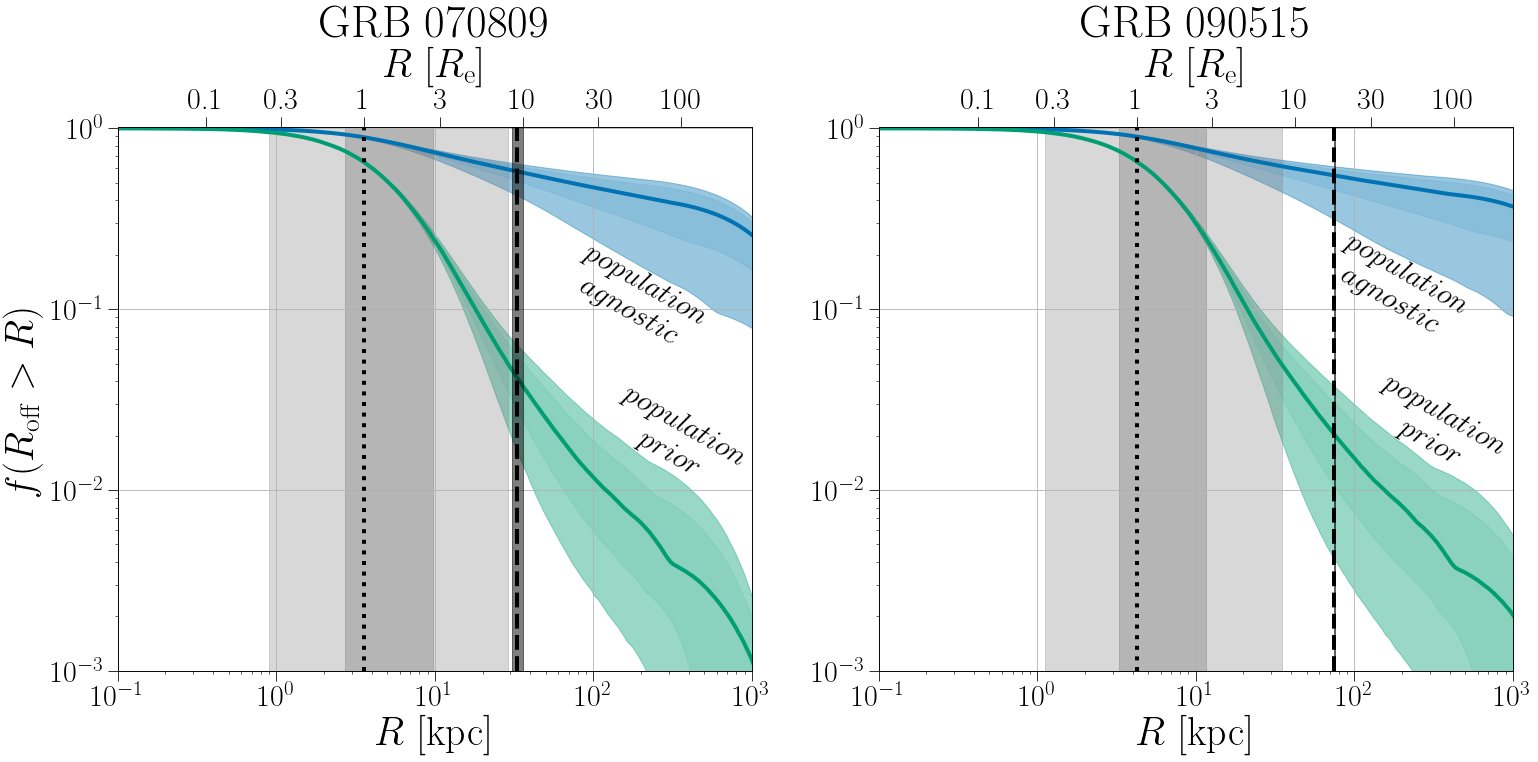

In [434]:
colors = sns.color_palette("colorblind")

plot_weighted_cdf(data, 'Rproj_offset', (1e-1, 1e3), lbl_dict, weighting=['prior', 'popsynth_weight'], 
                  credible=True, logx=True, logcdf=True, marginalize=True, cdf_min=1e-3)


In [250]:
def plot_weighted_pdf(grbs, param, limits, lbl_dict, logx=False, marginalize=False, credible=False, weighting=None, cdf_min=None, Nbins=None):
    f, axs = plt.subplots(len(grbs), 1, figsize=(12,16))
    
    for gidx, grb in enumerate(grbs.keys()):
        ax = axs[gidx]
        data = grbs[grb]

        Nsys = len(data[next(iter(data))]['tracers'])

        # get bins
        if not Nbins:
            Nbins = int(np.sqrt(Nsys))
            
        # find range of parameters
        maxval=0
        minval=1e6
        for sig in [-2,-1,0,1,2]:
            tracers = data['sigma'+(str(int(sig)))]['tracers']
            # get rid of values where minimum is zero
            tracers = tracers.loc[tracers[param]>0]
            if tracers[param].max() > maxval:
                maxval = tracers[param].max() 
            if tracers[param].min() < minval:
                minval = tracers[param].min()
        if maxval > 5e4:
            maxval = 5e4
        if minval < 1e-2:
            minval = 1e-2

        if logx==True:
            bins = np.logspace(np.log10(limits[0]), np.log10(limits[1]), Nbins)
        else:
            bins = np.linspace(limits[0], limits[1], Nbins)

        # label plots and axes scaling
        if logx==True:
            ax.set_xscale('log')

        if gidx==1:
            ax.set_xlabel(lbl_dict[param])
        ax.set_ylabel(r'$\widetilde{pdf}$')
                
                
            
        # plot the offset info
        for idx, run in enumerate(data):
            
            # mark the actual offset if this is the parameter
            if (idx==0) and ((param=='R_offset') or (param=='Rproj_offset')):
                galaxy = data[run]['galaxy']
                rad_eff = galaxy.obs_props['rad_eff'].value
                rad_offset = galaxy.obs_props['rad_offset'].value
                rad_offset_error = galaxy.obs_props['rad_offset_error'].value
                ax.axvline(rad_eff, color='k', linestyle=':', lw=4)
                ax.axvline(rad_offset, color='k', linestyle='--', lw=4)
                ax.axvspan((rad_offset - rad_offset_error), (rad_offset + rad_offset_error), color='k', alpha=0.4, zorder=20)
                    
        
        
        if credible==True:
            # plot the credible region
            tracers = data['sigma0']['tracers']

            if weighting:
                weights = tracers[weighting]
            else:
                weights = np.ones_like(tracers[param])

            low50 = wquantiles.quantile(tracers[param], weights, 0.25)
            high50 = wquantiles.quantile(tracers[param], weights, 0.75)
            low90 = wquantiles.quantile(tracers[param], weights, 0.05)
            high90 = wquantiles.quantile(tracers[param], weights, 0.95)
            ax.axvspan(low50, high50, color='gray', alpha=0.5)
            ax.axvspan(low90, high90, color='gray', alpha=0.3)

                
                
        ### MAIN PLOTTING ###
        
        # if specified, plot to 'marginalized' distributions
        if marginalize==True:
            # plot the median of the DM distribution
            mid = data['sigma0']
            if weighting:
                weights = mid['tracers'][weighting]
            else:
                weights = np.ones_like(tracers[param])
            h, bins = np.histogram(mid['tracers'][param], weights=weights, bins=bins, range=limits, density=True)
            bincents = (bins[1:]-bins[:-1])/2.0 + bins[:-1]
            
            ax.plot(bincents, h, color='b', alpha=1.0, lw=4)
            
            
            # now fill between the 1-sigma and 2-sigma bounds
            for sig, alpha in zip([1,2], [0.1,0.4]):
                low = data['sigma-'+(str(int(sig)))]
                high = data['sigma'+(str(int(sig)))]
               
                
                if weighting:
                    weights_low = low['tracers'][weighting]
                    weights_high = high['tracers'][weighting]
                else:
                    weights_low = np.ones_like(low['tracers'][param])
                    weights_high = np.ones_like(high['tracers'][param])
                
                h_low, bins_low = np.histogram(low['tracers'][param], weights=weights_low, bins=bins, range=limits, density=True)
                bincents_low = (bins_low[1:]-bins_low[:-1])/2.0 + bins_low[:-1]
                h_high, bins_high = np.histogram(high['tracers'][param], weights=weights_high, bins=bins, range=limits, density=True)
                bincents_high = (bins_high[1:]-bins_high[:-1])/2.0 + bins_high[:-1]
                
                ax.fill_between(bincents_low, h_low, h_high, color='b', alpha=alpha)
                
                
        else:
            # loop over the different runs
            for idx, run in enumerate(sigma_dict.keys()):
                tracers = data[run]['tracers']

                if weighting:
                    weights = tracers[weighting]
                else:
                    weights = np.ones_like(tracers[param])

                # plot pdf
                if gidx==1:
                    h, bins, _ = ax.hist(tracers[param], histtype='step', weights=weights, bins=bins, range=limits, alpha=0.7, color=colors[idx], density=True, lw=sigma_dict[run], label=lbl_dict[run])
                else:
                    h, bins, _ = ax.hist(tracers[param], histtype='step', weights=weights, bins=bins, range=limits, alpha=0.7, color=colors[idx], density=True, lw=sigma_dict[run])
                
                
                
        # titles
        for idx, run in enumerate(data):
            if (idx==0):
                galaxy = data[run]['galaxy']
                ax.set_title(r'GRB {0:s}'.format(galaxy.obs_props['name']))

        # limits
        ax.set_xlim(limits[0],limits[1])
        ax.set_ylim(0,0.003)
        ax.set_yticks([0,1e-3,2e-3,3e-3])
        ax.set_yticklabels(['0e-3','1e-3','2e-3','3e-3'])

        # legend
        if not marginalize:
            if gidx==1:
                ax.legend(prop={'size':27}, loc='upper left', ncol=1,)

            
    plt.tight_layout()
    #plt.savefig('/Users/michaelzevin/research/sgrb/paper_files/figures/'+param+'.png')
    

In [251]:
def plot_weighted_pdf_cdf(grbs, param, limits, lbl_dict, logx=False, logcdf=False, marginalize=False, credible=False, weighting=None, cdf_min=None, Nbins=None):
    f, both_axs = plt.subplots(2, len(grbs), figsize=(20,25))
    
    for gidx, grb in enumerate(grbs.keys()):
        axs = both_axs.T[gidx]
        data = grbs[grb]

        Nsys = len(data[next(iter(data))]['tracers'])

        # get bins
        if not Nbins:
            Nbins = int(np.sqrt(Nsys))

        if logx==True:
            bins = np.logspace(np.log10(limits[0]), np.log10(limits[1]), Nbins)
        else:
            bins = np.linspace(limits[0], limits[1], Nbins)

        # label plots and axes scaling
        for ax in axs:
            ax.set_xlim(limits[0],limits[1])
            if logx==True:
                ax.set_xscale('log')

        axs[1].set_xlabel(lbl_dict[param])
        if gidx==0:
            axs[0].set_ylabel(r'$\widetilde{pdf}$')

        if logcdf==True:
            if gidx==0:
                axs[1].set_ylabel(r'$1 - \widetilde{cdf}$')
            axs[1].set_yscale('log')
        else:
            if gidx==0:
                axs[1].set_ylabel(r'$\widetilde{cdf}$')
                
                
            
        # plot the offset info
        for idx, run in enumerate(data):
            
            # mark the actual offset if this is the parameter
            if (idx==0) and ((param=='R_offset') or (param=='Rproj_offset')):
                galaxy = data[run]['galaxy']
                rad_eff = galaxy.obs_props['rad_eff'].value
                rad_offset = galaxy.obs_props['rad_offset'].value
                rad_offset_error = galaxy.obs_props['rad_offset_error'].value
                for ax in axs:
                    ax.axvline(rad_eff, color='k', linestyle=':', lw=4)
                    ax.axvline(rad_offset, color='k', linestyle='--', lw=4)
                    ax.axvspan((rad_offset - rad_offset_error), (rad_offset + rad_offset_error), color='k', alpha=0.4)
                    
        
        
        if credible==True:
            # plot the credible region
            tracers = data['sigma0']['tracers']

            if weighting:
                weights = tracers[weighting]
            else:
                weights = np.ones_like(tracers[param])
            
            low90 = weighted_percentile(tracers[param], 25, weights=weights)
            high90 = weighted_percentile(tracers[param], 75, weights=weights)
            low99 = weighted_percentile(tracers[param], 25, weights=weights)
            high99 = weighted_percentile(tracers[param], 75, weights=weights)
            for ax in axs:
                ax.axvspan(low90, high90, color='gray', alpha=0.1)
                ax.axvspan(low99, high99, color='gray', alpha=0.08)

                
                
        ### MAIN PLOTTING ###
        
        # if specified, plot to 'marginalized' distributions
        if marginalize==True:
            # plot the median of the DM distribution
            mid = data['sigma0']
            if weighting:
                weights = mid['tracers'][weighting]
            else:
                weights = np.ones_like(tracers[param])
            h, bins = np.histogram(mid['tracers'][param], weights=weights, bins=bins, range=limits, density=True)
            bincents = (bins[1:]-bins[:-1])/2.0 + bins[:-1]
            
            axs[0].plot(bincents, h, color='b', alpha=1.0, lw=4)
            axs[1].plot(bincents, 1-(np.cumsum(h)/np.sum(h)), color='b', alpha=1.0, lw=4)
            
            
            # now fill between the 1-sigma and 2-sigma bounds
            for sig, alpha in zip([1,2], [0.1,0.4]):
                low = data['sigma-'+(str(int(sig)))]
                high = data['sigma'+(str(int(sig)))]
                
                if weighting:
                    weights_low = low['tracers'][weighting]
                    weights_high = high['tracers'][weighting]
                else:
                    weights_low = np.ones_like(low['tracers'][param])
                    weights_high = np.ones_like(high['tracers'][param])
                
                h_low, bins_low = np.histogram(low['tracers'][param], weights=weights_low, bins=bins, range=limits, density=True)
                bincents_low = (bins_low[1:]-bins_low[:-1])/2.0 + bins_low[:-1]
                h_high, bins_high = np.histogram(high['tracers'][param], weights=weights_high, bins=bins, range=limits, density=True)
                bincents_high = (bins_high[1:]-bins_high[:-1])/2.0 + bins_high[:-1]
                
                axs[0].fill_between(bincents_low, h_low, h_high, color='b', alpha=alpha)
                axs[1].fill_between(bincents_low, 1-(np.cumsum(h_low)/np.sum(h_low)), 1-(np.cumsum(h_high)/np.sum(h_high)), color='b', alpha=alpha)
                
                
        else:
            # loop over the different runs
            for idx, run in enumerate(data):
                tracers = data[run]['tracers']

                if weighting:
                    weights = tracers[weighting]
                else:
                    weights = np.ones_like(tracers[param])

                # plot pdf
                h, bins, _ = axs[0].hist(tracers[param], histtype='step', weights=weights, bins=bins, range=limits, alpha=0.7, density=True, lw=4)

                # plot cdf
                axs[1].plot(bins[:-1], 1-(np.cumsum(h)/np.sum(h)), label=lbl_dict[run], lw=4)
                
                
                
                
        # titles
        for idx, run in enumerate(data):
            if (idx==0):
                galaxy = data[run]['galaxy']
                axs[0].set_title('GRB{0:s} (z={1:0.2f})'.format(galaxy.obs_props['name'], galaxy.obs_props['redz']))

        # limits
        axs[0].set_ylim(0)
        if cdf_min:
            axs[1].set_ylim(cdf_min, 1.1)

        # legend
        if not marginalize:
            axs[1].legend(prop={'size':35}, loc='lower left')
            
        
    plt.tight_layout()
    #plt.savefig('/Users/michaelzevin/research/sgrb/paper_files/figures/Vsys.png')

### Weighted cdf of Vsys for systems that match the offset criteria

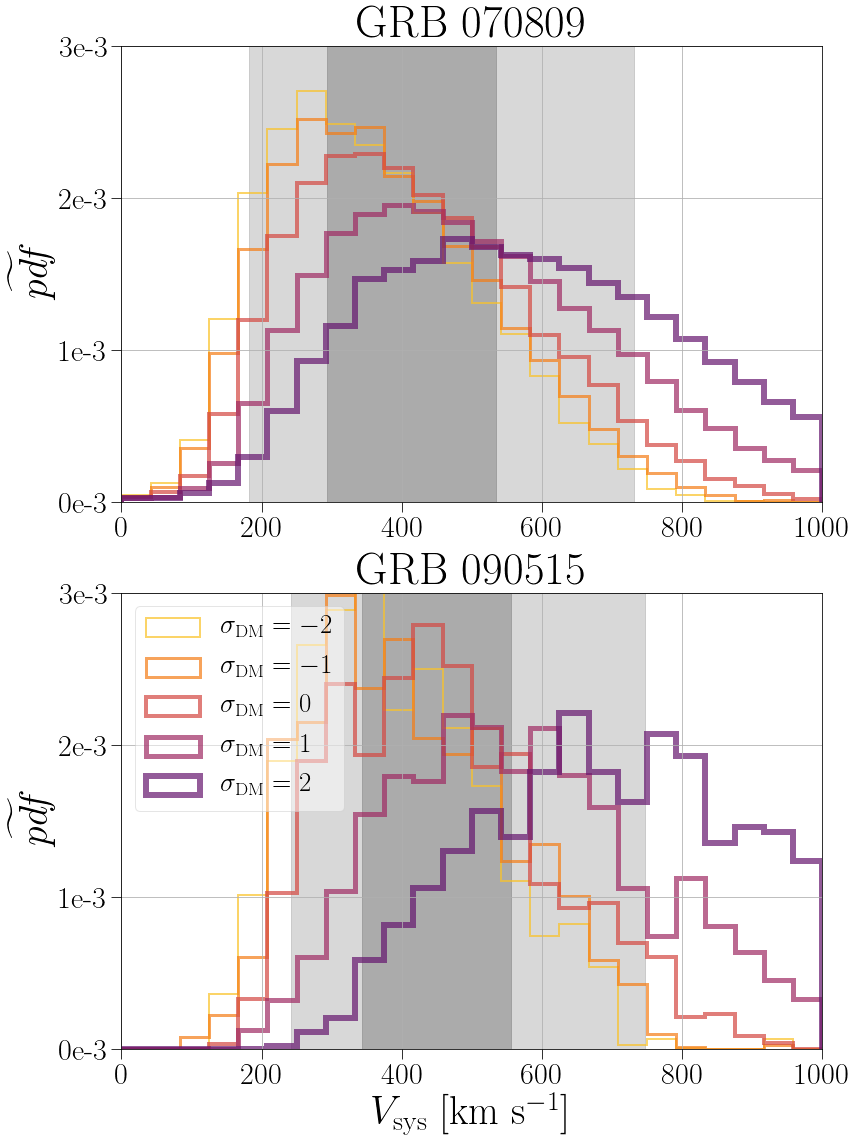

In [252]:
colors = sns.color_palette("inferno_r")

plot_weighted_pdf(data, 'Vsys', (0, 1e3), lbl_dict, weighting='obs_weight', credible=True, logx=False, marginalize=False, Nbins=25)

### Corner plot of Vsys and Tinsp weighted by observational weighting

In [372]:
def plot_kinparam_corner(grbs, credible=True, weighting=None):
    
    fig = plt.figure(figsize=(10,22))
    gs = gridspec.GridSpec(18,2, wspace=0.0, hspace=0.0)
    
    for gidx, grb in enumerate(grbs.keys()):
        print(grb)
        if gidx==0:
            Vsys_margax = fig.add_subplot(gs[0:4,0])
            Tinsp_margax = fig.add_subplot(gs[4:8,1])
            joint_ax = fig.add_subplot(gs[4:8,0])
            title_ax = fig.add_subplot(gs[0:4,1])
        elif gidx==1:
            Vsys_margax = fig.add_subplot(gs[10:14,0])
            Tinsp_margax = fig.add_subplot(gs[14:18,1])
            joint_ax = fig.add_subplot(gs[14:18,0])
            title_ax = fig.add_subplot(gs[10:14,1])
        
        data = grbs[grb]

        Nsys = len(data[next(iter(data))]['tracers'])

        if grb=='070809':
            Nbins=40
        elif grb=='090515':
            Nbins=20
        # get xbins and ybins
        xbins_hist = np.linspace(0,1000, Nbins)
        ybins_hist = np.linspace(1,10, Nbins)
        xbins_cont = np.linspace(0,1100, Nbins)
        ybins_cont = np.linspace(1,10, Nbins)
        
        
        if credible==True:
            # plot the credible region
            tracers = data['sigma0']['tracers']

            if weighting:
                weights = tracers[weighting]
            else:
                weights = np.ones_like(tracers['Vsys'])

            for (param, ax) in zip(['Vsys','Tinsp'],[Vsys_margax,Tinsp_margax]):
                low50 = wquantiles.quantile(tracers[param], weights, 0.25)
                high50 = wquantiles.quantile(tracers[param], weights, 0.75)
                low90 = wquantiles.quantile(tracers[param], weights, 0.05)
                high90 = wquantiles.quantile(tracers[param], weights, 0.95)
                if param == 'Vsys':
                    ax.axvspan(low50, high50, color='gray', alpha=0.25, zorder=-20)
                    ax.axvspan(low90, high90, color='gray', alpha=0.15, zorder=-20)
                elif param == 'Tinsp':
                    ax.axhspan(low50, high50, color='gray', alpha=0.25, zorder=-20)
                    ax.axhspan(low90, high90, color='gray', alpha=0.15, zorder=-20)
            
            
        ### Main plotting
        
        # loop over the different runs
        for idx, run in enumerate(sigma_dict.keys()):
            print('   ',run)
            tracers = data[run]['tracers']

            if weighting:
                weights = tracers[weighting]
            else:
                weights = np.ones_like(tracers['Vsys'])

            # plot marginalized pdfs
            h, bins, _ = Vsys_margax.hist(tracers['Vsys'], histtype='step', weights=weights, bins=xbins_hist, alpha=0.7, color=colors[idx], \
                                            density=True, lw=sigma_dict[run], zorder=-idx)
            h, bins, _ = Tinsp_margax.hist(tracers['Tinsp'], histtype='step', weights=weights, bins=ybins_hist, alpha=0.7, color=colors[idx], \
                                          density=True, orientation='horizontal', lw=sigma_dict[run], zorder=-idx)
            
            print(wquantiles.quantile(tracers['Tinsp'], weights, 0.5))
            # scatterplot all points for each sample
            sampled_points = tracers.sample(1000, weights=tracers[weighting]).index
            joint_ax.scatter(tracers['Vsys'].loc[sampled_points], tracers['Tinsp'].loc[sampled_points], s=3.0, alpha=0.1, color=colors[idx], rasterized=True)
            
            # weighted contours
            heights, xb, yb = np.histogram2d(tracers['Vsys'], tracers['Tinsp'], bins=[xbins_cont,ybins_cont], weights=tracers[weighting], normed=True)
            # calculate the volume element for each bin
            dx, dy = xb[1:] - xb[:-1], yb[1:] - yb[:-1]
            bin_dims = np.asarray(list(itertools.product(dx,dy)))
            dv = np.multiply(bin_dims[:,0], bin_dims[:,1]).reshape((len(xb)-1,len(yb)-1))
            dv = dv.flatten()
            # determine the indices of the bins, decreasing in height
            heights = heights.flatten()
            hsort = heights.argsort()[::-1]
            # get threshold values
            thresholds = [90]
            thresh=[]
            for t in thresholds[::-1]:
                hist_idx = np.argwhere(heights[hsort].cumsum() * dv[hsort] > t/100.)[0]
                thresh_val = heights[hsort][hist_idx]
                thresh.append(thresh_val)
            thresh = np.asarray(thresh).flatten()
    
            # THERE HAS TO BE SOME KIND OF ISSUE WHEN RESHAPING!
            # plot using matplotlib's contour
            xbins_cent = xb[1:] + (xb[1:]-xb[:-1])/2.0
            ybins_cent = yb[1:] + (yb[1:]-yb[:-1])/2.0
            joint_ax.contour(xbins_cent, ybins_cent, heights.reshape(xbins_cent.shape[0], ybins_cent.shape[0]).T, \
                        levels=thresh, colors=[colors[idx]], linewidths=[sigma_dict[run]], alpha=0.7, zorder=-idx)
                
               
            
        ### Formatting 
        
        # titles
        for idx, run in enumerate(data):
            if (idx==0):
                galaxy = data[run]['galaxy']
                title_ax.set_title(r'GRB {0:s}'.format(galaxy.obs_props['name']), fontsize=50, y=0.43)
                title_ax.axis('off')

        # limits
        joint_ax.set_xlim(0,1100)
        joint_ax.set_ylim(1,10)
        Vsys_margax.set_xlim(0,1100)
        Tinsp_margax.set_ylim(1,10)
        
        # labels
        joint_ax.set_xlabel(r'$V_{\rm sys}$ [km\,s$^{-1}$]', fontsize=45)
        joint_ax.set_ylabel(r'$t_{\rm insp}$ [Gyr]', fontsize=45)
            
        # ticks
        joint_ax.set_xticks([0,250,500,750,1000])
        joint_ax.set_xticklabels([0,250,500,750,1000], rotation=-60)
        joint_ax.set_yticks([1,3,5,7,9])
        Vsys_margax.set_xticks([0,250,500,750,1000])
        Vsys_margax.set_yticks([])
        Tinsp_margax.set_xticks([])
        Tinsp_margax.set_yticks([1,3,5,7,9])
        for ax in [Vsys_margax, Tinsp_margax]:
            ax.set_xticklabels([])
            ax.set_yticklabels([])

        # legend
        
        if gidx==0:
            for idx, run in enumerate(sigma_dict.keys()):
                string = run[5:]
                name = string.split('_')[0]
                joint_ax.plot([0],[0], label=name, color=colors[idx], lw=sigma_dict[run])
            plt.figlegend(prop={'size':27}, loc='lower center', ncol=5, title=r'$\sigma_{\rm DM}$', title_fontsize=45)
            
    fig.subplots_adjust(bottom=0.18, left=0.14, right=0.97, top=0.98)
    plt.savefig('/Users/michaelzevin/research/sgrb/paper_files/figures/kinematic_corner.png', dpi=200)
    plt.savefig('/Users/michaelzevin/research/sgrb/paper_files/figures/kinematic_corner.pdf', dpi=200)

070809
    sigma-2
2.738863758052588
    sigma-1
2.7196630942533844
    sigma0
2.735336980164539
    sigma1
2.644833886825821
    sigma2
2.7552520932591227
090515
    sigma-2
4.904244760001082
    sigma-1
4.950945724153813
    sigma0
5.042224347042767
    sigma1
4.805930500871869
    sigma2
5.031172204465583


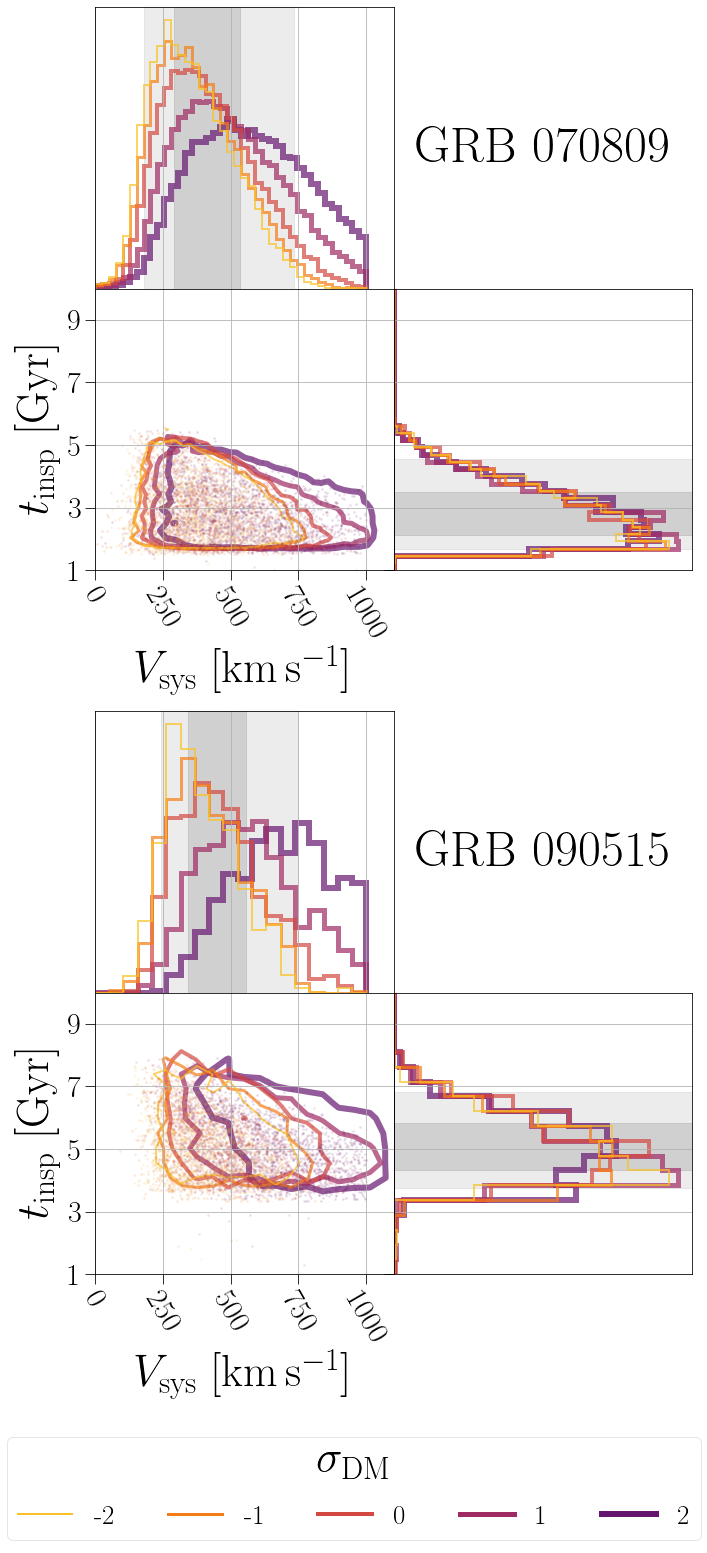

In [373]:
colors = sns.color_palette("inferno_r")

plot_kinparam_corner(data, credible=True, weighting='obs_weight')

### Roffset evolution

In [256]:
### Read in data with trajectories
grbs = ['070809']
runs=['sigma0','sigma1','sigma2','sigma-1','sigma-2']
data_traj={}

bpath = '/Users/michaelzevin/research/sgrb/output_files/'

for grb in grbs:
    print(grb)
    data_traj[grb] = {}

    for run in runs:
        print('  '+run)
        run_name = grb+'_'+run+'_timesteps'
        dirpath = os.path.join(bpath, grb, run_name)
        data_traj[grb][run] = {}

        data_traj[grb][run]['galaxy'] = pickle.load(open(os.path.join(dirpath, 'galaxy.pkl'), 'rb'))

        output_keys = list(h5py.File(os.path.join(dirpath, 'output.hdf'), 'r').keys())

        if processed_data_name in output_keys:
            # check to see if data has already been processed
            tracers = pd.read_hdf(os.path.join(dirpath, 'output.hdf'), key=processed_data_name)
            
            
        else:
            # calculated weights...this takes time
            tracers = pd.read_hdf(os.path.join(dirpath, 'output.hdf'), key='tracers')

            tracers['popsynth_weight'] = convolve.weight_tracers_from_samples(tracers, Vsys, Tinsp)
            tracers['popsynth_weight'] = tracers['popsynth_weight'] * (1./np.sum(tracers['popsynth_weight']))
            
            offset = data_traj[grb][run]['galaxy'].obs_props['rad_offset'].value
            offset_error = data_traj[grb][run]['galaxy'].obs_props['rad_offset_error'].value
            tracers['obs_weight'] = convolve.weight_tracers_from_observations(tracers, offset, offset_error, normalize=True)
            tracers['combined_weight'] = convolve.combine_weights([tracers['obs_weight'], tracers['popsynth_weight']], combine_method='multiply')

            tracers.to_hdf(os.path.join(dirpath, 'output.hdf'), key=processed_data_name)

        data_traj[grb][run]['tracers'] = tracers
        

070809
  sigma0
  sigma1
  sigma2
  sigma-1
  sigma-2


In [257]:
def weighted_median(data, weights):
    """
    calculate a weighted median
    @author Jack Peterson (jack@tinybike.net)
    """
    data, weights = np.array(data).squeeze(), np.array(weights).squeeze()
    s_data, s_weights = map(np.array, zip(*sorted(zip(data, weights))))
    midpoint = 0.5 * sum(s_weights)
    if any(weights > midpoint):
        w_median = (data[weights == np.max(weights)])[0]
    else:
        cs_weights = np.cumsum(s_weights)
        idx = np.where(cs_weights <= midpoint)[0][-1]
        if cs_weights[idx] == midpoint:
            w_median = np.mean(s_data[idx:idx+2])
        else:
            w_median = s_data[idx+1]
    return w_median

def offset_evolution_weighted(data, grb, timeslices=[5.0,4.0,3.0,2.0,1.0], weighting=None, downsamp=None, saved_vals=None):
    fig = plt.figure(figsize=(20,14))
    
    gs = gridspec.GridSpec(3, len(timeslices))
    Nsys = 1e5
    
    timeslice_axs = []
    for i in range(len(timeslices)):
        timeslice_axs.append(fig.add_subplot(gs[0,i]))
    for idx, ax in enumerate(timeslice_axs):
        ax.set_xlim(1e-1, 2e3)
        ax.set_ylim(Nsys*5e-5, Nsys*2e-1)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xticks([1e-1,1e0,1e1,1e2,1e3])
        ax.set_yticks(np.asarray([1e-4,1e-3,1e-2,1e-1])*Nsys)
        ax.set_xlabel(r'$R_{\rm off}$ [kpc]', zorder=10)
        ax.tick_params(axis='both', which='major', labelsize=25, zorder=10)
        if idx == 0:
            ax.set_ylabel(r'$\frac{\mathrm{d}N}{\mathrm{d} \log_{10}R_{\rm off}}$')
        else:
            ax.set_yticklabels([])
            
    hist_bins = np.logspace(-1,4,50)
    
    evo_ax = fig.add_subplot(gs[1:,:])
    evo_ax_redz = evo_ax.twiny()
    evo_ax_sfr = evo_ax.twinx()
    evo_ax_sfr.grid(False)
    evo_ax_redz.grid(False)

    # label axes
    evo_ax.set_xlabel(r'$t_{\rm GRB}-t$ [Gyr]')
    evo_ax.set_ylabel(r'$R_{\rm off}$ [kpc]')
    evo_ax_redz.set_xlabel('$z$')
    
    # --- manufacture time and redshift axes
    gal = data[grb]['sigma0']['galaxy']
    # set time axis
    times = gal.times[-1]-gal.times
    evo_ax.set_xlim(times[0].value,times[-1].value)
    if popsynth_met == 'Z1':
        evo_ax_ymax = 20
    elif popsynth_met == 'Z10':
        evo_ax_ymax = 65
    evo_ax.set_ylim(0,evo_ax_ymax)
    
    # plot redshift axis values
    redz_vals = np.arange(0.5, gal.redz[0], 0.5)[::-1]
    time_vals = cosmo.age(gal.obs_props['redz']) - cosmo.age(redz_vals)
    evo_ax_redz.set_xlim(times[0].value,times[-1].value)
    evo_ax_redz.plot(times, -10*np.ones_like(gal.times))
    evo_ax_redz.set_xlabel('$z$', zorder=10)
    evo_ax_redz.grid(False)
    evo_ax_redz.set_xticks(time_vals.value)
    evo_ax_redz.set_xticklabels(redz_vals, zorder=10)
    
    # plot SFR
    evo_ax_sfr.set_ylabel('SFR [M$_\odot$ yr$^{-1}$]', color='royalblue', labelpad=5)
    evo_ax_sfr.plot(times, gal.sfr, linewidth=4, color='royalblue', linestyle='--', zorder=-15, alpha=0.6)
    evo_ax_sfr.set_ylim(0,gal.sfr.value.max()+2)
    evo_ax_sfr.grid(False)

    t_spacing = 0.25   # Gyr
    
    # save all stuff for later
    if saved_vals:
        all_Rs = saved_vals['all_Rs']
        all_Ts = saved_vals['all_Ts']
        hist_weights = saved_vals['hist_weights']
        hist_Rs = saved_vals['hist_Rs']
    else:
        all_Rs = {}
        all_Ts = {}
        hist_weights = {}
        hist_Rs = {}

    sigma_dict = {'sigma-2': 2, 'sigma-1': 3, 'sigma0': 4, 'sigma1': 5, 'sigma2': 6}
    for sidx, sigma in enumerate(sigma_dict.keys()):
        
        print(sigma)
        if saved_vals:
            evo_ax.plot(all_Ts[sigma], all_Rs[sigma], color=colors[sidx], linewidth=sigma_dict[sigma], label=lbl_dict[sigma])
            for histidx, timeslice in enumerate(timeslices):
                h, bins, _ = timeslice_axs[histidx].hist(hist_Rs[sigma][histidx], bins=hist_bins, color=colors[sidx], histtype='step', lw=3, alpha=0.7, weights=Nsys*hist_weights[sigma][histidx])
                timeslice_axs[histidx].axvline(np.average(hist_Rs[sigma][histidx], weights=hist_weights[sigma][histidx]), color=colors[sidx], alpha=0.7, lw=2)
            continue

        gal = data[grb][sigma]['galaxy']
        tracers = data[grb][sigma]['tracers']
        
        # read trajectories separately every time since they are heavyyy
        bpath = '/Users/michaelzevin/research/sgrb/output_files/'
        run_name = grb+'_'+sigma+'_timesteps'
        dirpath = os.path.join(bpath, grb, run_name)
        traj = pd.read_hdf(os.path.join(dirpath, 'output.hdf'), key='trajectories')
        t_bins = np.arange(gal.time_end.value, gal.time_beg.value, -t_spacing)[::-1]
        t_bins = np.insert(t_bins, 0, gal.time_beg.value)
        
        # downsample if specified
        if downsamp:
            indices = np.random.choice(tracers.index.unique(), downsamp)
            traj = traj.loc[indices]
            tracers = tracers.loc[indices]


        T_vals = []
        R_vals = []
        hist_weight_vals = []
        hist_R_vals = []
        no_vals = []

        for idx, t in tqdm(enumerate(t_bins[:-1]), total=len(t_bins[:-1])):

            tstep_traj = traj.loc[(traj.time >= t_bins[idx]) & (traj.time < t_bins[idx+1])]

            Rs = tstep_traj.groupby('idx').last()['Rproj_offset']
            
            if weighting != None:
                weights = tracers.loc[Rs.index][weighting]
            else:
                weights = np.ones(len(tracers.loc[Rs.index]))
                
            # we need the weights to sum to unity for this plot to look normalized across different sigma
            weights = weights / np.sum(weights)
                
            T_vals.append(gal.times[-1].value - t_bins[idx+1])
            
            # if there are steps, append weighted average
            if len(Rs)==0:
                R_vals.append(0.0)
                no_vals.append(idx)
            else:
                R_vals.append(np.average(Rs, weights=weights))
                #R_vals.append(weighted_median(Rs, weights))

                # plot histogram if at the right tstep
                for histidx, timeslice in enumerate(timeslices):
                    if (timeslice <= (gal.times[-1].value - t_bins[idx])) & (timeslice > (gal.times[-1].value - t_bins[idx+1])):
                        
                        # scale the weight by the cumulative sfr at that time
                        tstep_idx = np.argwhere(gal.times.value <= t_bins[idx])[-1]
                        sfr_weight = float(np.cumsum(gal.sfr.value)[tstep_idx]) / np.sum(gal.sfr.value)
                        weights *= sfr_weight
                        
                        h, bins, _ = timeslice_axs[histidx].hist(Rs, bins=hist_bins, color=colors[sidx], histtype='step', lw=3, alpha=0.7)#, weights=weights)
                        timeslice_axs[histidx].axvline(np.average(Rs, weights=weights), color=colors[sidx], alpha=0.7, lw=2)
                        
                        hist_weight_vals.append(np.asarray(weights))
                        hist_R_vals.append(np.asarray(Rs))
                            
        T_vals = np.asarray(T_vals)
        R_vals = np.asarray(R_vals)
        evo_ax.plot(T_vals, R_vals, color=colors[sidx], linewidth=sigma_dict[sigma], label=lbl_dict[sigma])
        
        
        all_Rs[sigma] = R_vals
        all_Ts[sigma] = T_vals
        hist_weights[sigma] = hist_weight_vals
        hist_Rs[sigma] = hist_R_vals
        
        print("no values at the following indices: ", no_vals)
        
        
    # add boxes and connecing lines between plots
    for tidx, timeslice in enumerate(timeslices):
        times = all_Ts['sigma0']
        rads_low = all_Rs['sigma2']
        rads_high = all_Rs['sigma-2']
        
        time_index = np.argwhere(times < timeslice)[0]
        
        left, right = float(times[time_index-1]), float(times[time_index])
        bottom = float(np.mean([rads_low[time_index-1],rads_low[time_index]])-5)
        top = float(np.mean([rads_high[time_index-1],rads_high[time_index]])+5)
        top = evo_ax_ymax
        
        left_con = ConnectionPatch(xyA=(left,top), xyB=(0,0), coordsA="data", coordsB="axes fraction",
                          axesA=evo_ax, axesB=timeslice_axs[tidx], color="gray", zorder=-10, alpha=0.3, lw=1, linestyle=':')
        right_con = ConnectionPatch(xyA=(right,top), xyB=(1,0), coordsA="data", coordsB="axes fraction",
                          axesA=evo_ax, axesB=timeslice_axs[tidx], color="gray", zorder=-10, alpha=0.3, lw=1, linestyle=':')
        evo_ax.add_artist(left_con)
        evo_ax.add_artist(right_con)
        evo_ax.axvspan(left, right, color='k', alpha=0.1)
        timeslice_axs[tidx].set_title(r'$t \simeq t_{\rm GRB} - %0.1f$ Gyr' % timeslice, fontsize=25)

        
        
        
    
    evo_ax.legend(prop={'size':30}, loc=3, ncol=5, bbox_to_anchor=(0., -0.35, 1, 0.2), mode="expand", borderaxespad=0.)
    plt.tight_layout(h_pad=3)
    plt.savefig('/Users/michaelzevin/research/sgrb/paper_files/figures/weighted_offset.png', dpi=200)
    plt.savefig('/Users/michaelzevin/research/sgrb/paper_files/figures/weighted_offset.pdf', dpi=200)
    
    saved_dat = {'all_Rs': all_Rs, 'all_Ts': all_Ts, 'hist_weights': hist_weights, 'hist_Rs': hist_Rs}
    return saved_dat

In [371]:
(gal.mass_stars[-1] - gal.mass_stars[122]) / gal.mass_stars[-1]

<Quantity 0.01361181>

In [360]:
np.sum(saved_dat['hist_Rs']['sigma0'][0]) / np.sum(saved_dat['hist_Rs']['sigma0'][4])

0.016823289518566903

sigma-2
sigma-1
sigma0
sigma1
sigma2


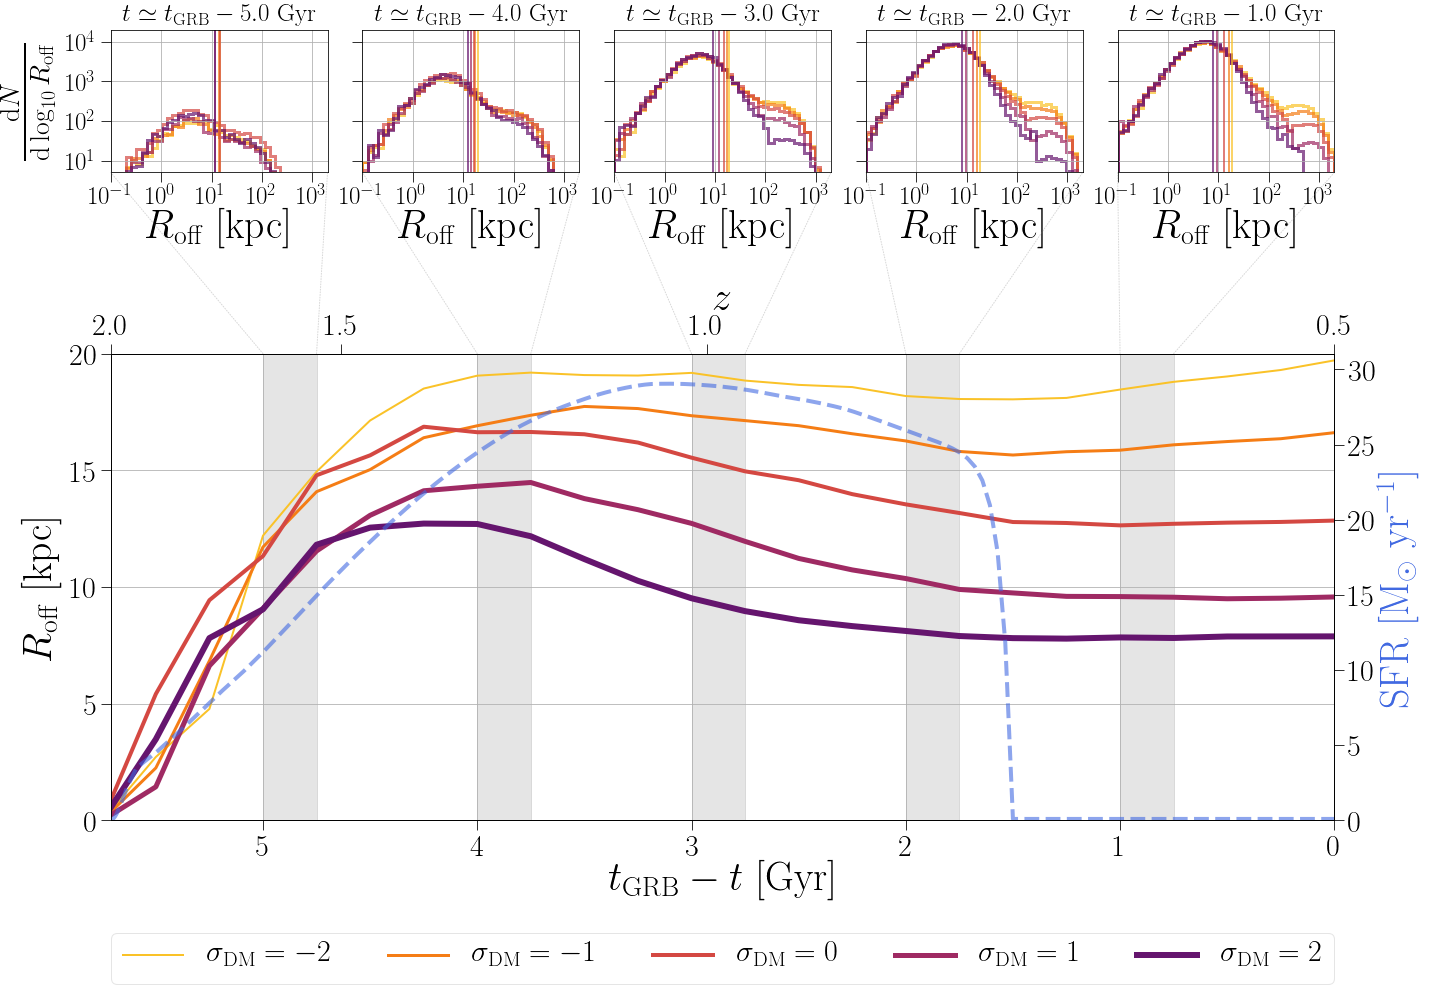

In [258]:
colors = sns.color_palette("inferno_r")

pkl_path = '/Users/michaelzevin/research/sgrb/output_files/070809/weighted_offset_'+\
                popsynth_run+'_'+popsynth_met+'.pkl'

# read in pickled file if it exists
if os.path.exists(pkl_path):
    with open(pkl_path, 'rb') as path:
        saved_dat = pickle.load(path)
else:
    saved_dat=None

# run plotting script
saved_dat = offset_evolution_weighted(data_traj, '070809', weighting='popsynth_weight', saved_vals=saved_dat)

# save info as pickle if file was not already there
if not os.path.exists(pkl_path):
    with open(pkl_path, 'wb') as path:
        pickle.dump(saved_dat, path)

### Violin plot

"We use two priors, one uninformed prior on the population parameters and one which uses the output of population modeling as the prior distribution on population parameters." 

#### Each violin should have four different histograms: two priors (flat, popsynth) and two posteriors. 

Get the heights and bins of all histrograms. For GRB090515, take the negative of the bin heights. Make (smooth) line plot or step plot connecting bins

In [261]:
# process combined popsynth data...THIS TAKES TIME
sigmas = [-2,-1,0,1,2]
grbs = ['070809', '090515']

popsynth_path = os.path.join('/Users/michaelzevin/research/sgrb/pop_models/production',popsynth_run,popsynth_met)

if os.path.exists(os.path.join(popsynth_path,'weighted_popsynth.hdf')):
    combined_popsynth_data = pd.read_hdf(os.path.join(popsynth_path,'weighted_popsynth.hdf'), key='popsynth')
else:
    combined_popsynth_data = pd.DataFrame()

    # combined popsynth data
    for gidx, grb in enumerate(grbs):
        print(grb)
        for sidx, sigma in enumerate(sigmas):
            print('   ',sigma)
            df = popsynth_data.copy()
            df['grb'] = grb
            df['sigma'] = sigma

            tracers = data[grb]['sigma'+str(sigma)]['tracers']
            gal = data[grb]['sigma'+str(sigma)]['galaxy']
            weights = convolve.weight_samples_from_tracers(tracers, gal.obs_props['rad_offset'], gal.obs_props['rad_offset_error'], popsynth_data['Vsys'], popsynth_data['Tinsp'])
            df['weights'] = weights

            combined_popsynth_data = combined_popsynth_data.append(df)
            
    combined_popsynth_data.to_hdf(os.path.join(popsynth_path,'weighted_popsynth.hdf'), key='popsynth')


In [401]:
def violin_plot_DM(data, param, lbl_dict, param_range=(0,1000), Nbins=100, logbins=False):
    fig, axs = plt.subplots(1, 5, figsize=(5*len(sigmas),10))
    
    # keep track of maximum bin heights
    hmax=[]
    
    for sidx, sigma in enumerate(sigmas):
        ax = axs[sidx]
        # format plot
        ax.set_xticklabels([])
        if sidx != 0:
            ax.set_yticklabels([])
        if sidx==0:
            ax.set_ylabel(lbl_dict[param])
        ax.set_ylim(param_range)
            
        # remove grid and axeslines
        ax.grid(False)
        ax.tick_params(axis='both', which='both', length=0)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        
        if logbins:
            bins = np.logspace(np.log10(param_range[0]), np.log10(param_range[1]), Nbins)
            ax.set_yscale('log')
        else:
            bins = np.linspace(param_range[0], param_range[1], Nbins)
        
        
        lw=4
        grbs = ['070809', '090515']
        for gidx, grb in enumerate(grbs):
            data_tmp = data.loc[(data['sigma'] == sigma) & (data['grb'] == grb)]
        
            # plot histograms
            h, _ = np.histogram(data_tmp[param], weights=None, bins=bins, range=param_range, density=True)
            h_weighted, bins_weighted = np.histogram(data_tmp[param], weights=data_tmp['weights'], bins=bins, range=param_range, density=True)
            if grb=='090515':
                print(np.sum(h_weighted[np.argwhere(bins_weighted <= 50)[:-1]])/np.sum(h_weighted))
            
            
            if logbins:
                bin_widths = bins[1:]-bins[:-1]
                h = h*bin_widths
                h_weighted = h_weighted*bin_widths
                
            hmax.append([h.max(),h_weighted.max()])
        
            low90 = wquantiles.quantile(data_tmp[param], data_tmp['weights'], 0.05)
            high90 = wquantiles.quantile(data_tmp[param], data_tmp['weights'], 0.95)
            #if sigma==2:
            #    print(sigma, wquantiles.quantile(data_tmp[param], data_tmp['weights'], 0.0007))
            
            if gidx==0:
                ax.plot(-np.append(h,0), bins, drawstyle="steps", color=colors[0], lw=lw, linestyle='--')
                ax.plot(-np.append(h_weighted,0), bins, drawstyle="steps", color=colors[0], lw=lw, linestyle='-')
                ax.axhline(low90, xmin=0, xmax=0.5, color=colors[0], lw=lw, linestyle=':')
                ax.axhline(high90, xmin=0, xmax=0.5, color=colors[0], lw=lw, linestyle=':')
                ax.fill_betweenx(bins, -np.append(h_weighted,0), np.zeros(len(h_weighted)+1), step="post", color=colors[0], alpha=0.3)
            elif gidx==1:
                ax.plot(np.append(h,0), bins, drawstyle="steps", color=colors[1], lw=lw, linestyle='--')
                ax.plot(np.append(h_weighted,0), bins, drawstyle="steps", color=colors[1], lw=lw, linestyle='-')
                ax.axhline(low90, xmin=0.5, xmax=1, color=colors[1], lw=lw, linestyle=':')
                ax.axhline(high90, xmin=0.5, xmax=1, color=colors[1], lw=lw, linestyle=':')
                ax.fill_betweenx(bins, np.zeros(len(h_weighted)+1), np.append(h_weighted,0), step="post", color=colors[1], alpha=0.3)
                
        ax.set_title(r'$\sigma_{\rm DM}=$ %s' % str(sigma))
        
                
        # create center line and center ticks
        ax.axvline(0, color='k', alpha=0.7)
        for line in np.linspace(param_range[0],param_range[1],6):
            ax.axhline(line, xmin=0.47, xmax=0.53, color='k', alpha=0.7, lw=4)
        ax.grid(True, axis='y')
        

    for idx, ax in enumerate(axs):
        ax.set_xlim(-1.1*np.max(hmax), 1.1*np.max(hmax))
        if idx==2:
            ax.annotate(r'GRB', xy=(-0.02,0.93), xycoords='axes fraction', color=colors[0], fontsize=40)
            ax.annotate(r'070809', xy=(0.07,0.88), xycoords='axes fraction', color=colors[0], fontsize=40)
            ax.annotate(r'GRB', xy=(0.55,0.93), xycoords='axes fraction', color=colors[1], fontsize=40)
            ax.annotate(r'090515', xy=(0.64,0.88), xycoords='axes fraction', color=colors[1], fontsize=40)
        
    plt.tight_layout(w_pad=1)
    plt.savefig('/Users/michaelzevin/research/sgrb/paper_files/figures/Vkick_DM.png')
    plt.savefig('/Users/michaelzevin/research/sgrb/paper_files/figures/Vkick_DM.pdf', dpi=200)
    

In [398]:
def violin_plot_DM_proposal(data, param, lbl_dict, param_range=(0,1000), Nbins=100, logbins=False):
    fig, ax = plt.subplots(1, 1, figsize=(8,10))
    
    # keep track of maximum bin heights
    hmax=[]
    
    sigma=0
    # format plot
    ax.set_xticklabels([])
    ax.set_ylabel(lbl_dict[param])
    ax.set_ylim(param_range)

    # remove grid and axeslines
    ax.grid(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    if logbins:
        bins = np.logspace(np.log10(param_range[0]), np.log10(param_range[1]), Nbins)
        ax.set_yscale('log')
    else:
        bins = np.linspace(param_range[0], param_range[1], Nbins)
        
        
    lw=4
    grbs = ['070809', '090515']
    for gidx, grb in enumerate(grbs):
        data_tmp = data.loc[(data['sigma'] == sigma) & (data['grb'] == grb)]

        # plot histograms
        h, _ = np.histogram(data_tmp[param], weights=None, bins=bins, range=param_range, density=True)
        h_weighted, bins_weighted = np.histogram(data_tmp[param], weights=data_tmp['weights'], bins=bins, range=param_range, density=True)
        print(np.sum(h_weighted[np.argwhere(bins_weighted > 200)[:-1]])/np.sum(h_weighted))


        if logbins:
            bin_widths = bins[1:]-bins[:-1]
            h = h*bin_widths
            h_weighted = h_weighted*bin_widths

        hmax.append([h.max(),h_weighted.max()])

        low90 = wquantiles.quantile(data_tmp[param], data_tmp['weights'], 0.05)
        high90 = wquantiles.quantile(data_tmp[param], data_tmp['weights'], 0.95)

        if gidx==0:
            ax.plot(-np.append(h,0), bins, drawstyle="steps", color=colors[0], lw=lw, linestyle='--')
            ax.plot(-np.append(h_weighted,0), bins, drawstyle="steps", color=colors[0], lw=lw, linestyle='-')
            ax.axhline(low90, xmin=0, xmax=0.5, color=colors[0], lw=lw, linestyle=':')
            ax.axhline(high90, xmin=0, xmax=0.5, color=colors[0], lw=lw, linestyle=':')
            ax.fill_betweenx(bins, -np.append(h_weighted,0), np.zeros(len(h_weighted)+1), step="post", color=colors[0], alpha=0.3)
        elif gidx==1:
            ax.plot(np.append(h,0), bins, drawstyle="steps", color=colors[1], lw=lw, linestyle='--')
            ax.plot(np.append(h_weighted,0), bins, drawstyle="steps", color=colors[1], lw=lw, linestyle='-')
            ax.axhline(low90, xmin=0.5, xmax=1, color=colors[1], lw=lw, linestyle=':')
            ax.axhline(high90, xmin=0.5, xmax=1, color=colors[1], lw=lw, linestyle=':')
            ax.fill_betweenx(bins, np.zeros(len(h_weighted)+1), np.append(h_weighted,0), step="post", color=colors[1], alpha=0.3)


    # create center line and center ticks
    ax.axvline(0, color='k', alpha=0.7)
    for line in np.linspace(param_range[0],param_range[1],6):
        ax.axhline(line, xmin=0.47, xmax=0.53, color='k', alpha=0.7, lw=4)
    ax.grid(True, axis='y')


    ax.set_xlim(-1.1*np.max(hmax), 1.1*np.max(hmax))
    ax.annotate(r'GRB', xy=(0.10,0.93), xycoords='axes fraction', color=colors[0], fontsize=40)
    ax.annotate(r'070809', xy=(0.19,0.88), xycoords='axes fraction', color=colors[0], fontsize=40)
    ax.annotate(r'GRB', xy=(0.55,0.93), xycoords='axes fraction', color=colors[1], fontsize=40)
    ax.annotate(r'090515', xy=(0.64,0.88), xycoords='axes fraction', color=colors[1], fontsize=40)
        
    plt.tight_layout(w_pad=1)
    plt.savefig('/Users/michaelzevin/research/sgrb/paper_files/figures/Vkick_DM.png', dpi=200)
    plt.savefig('/Users/michaelzevin/research/sgrb/paper_files/figures/Vkick_DM.pdf', dpi=200)    

0.05533858262657761
0.061836570546894995
0.024483063089336222
0.02330314825125682
0.0016409074039238445


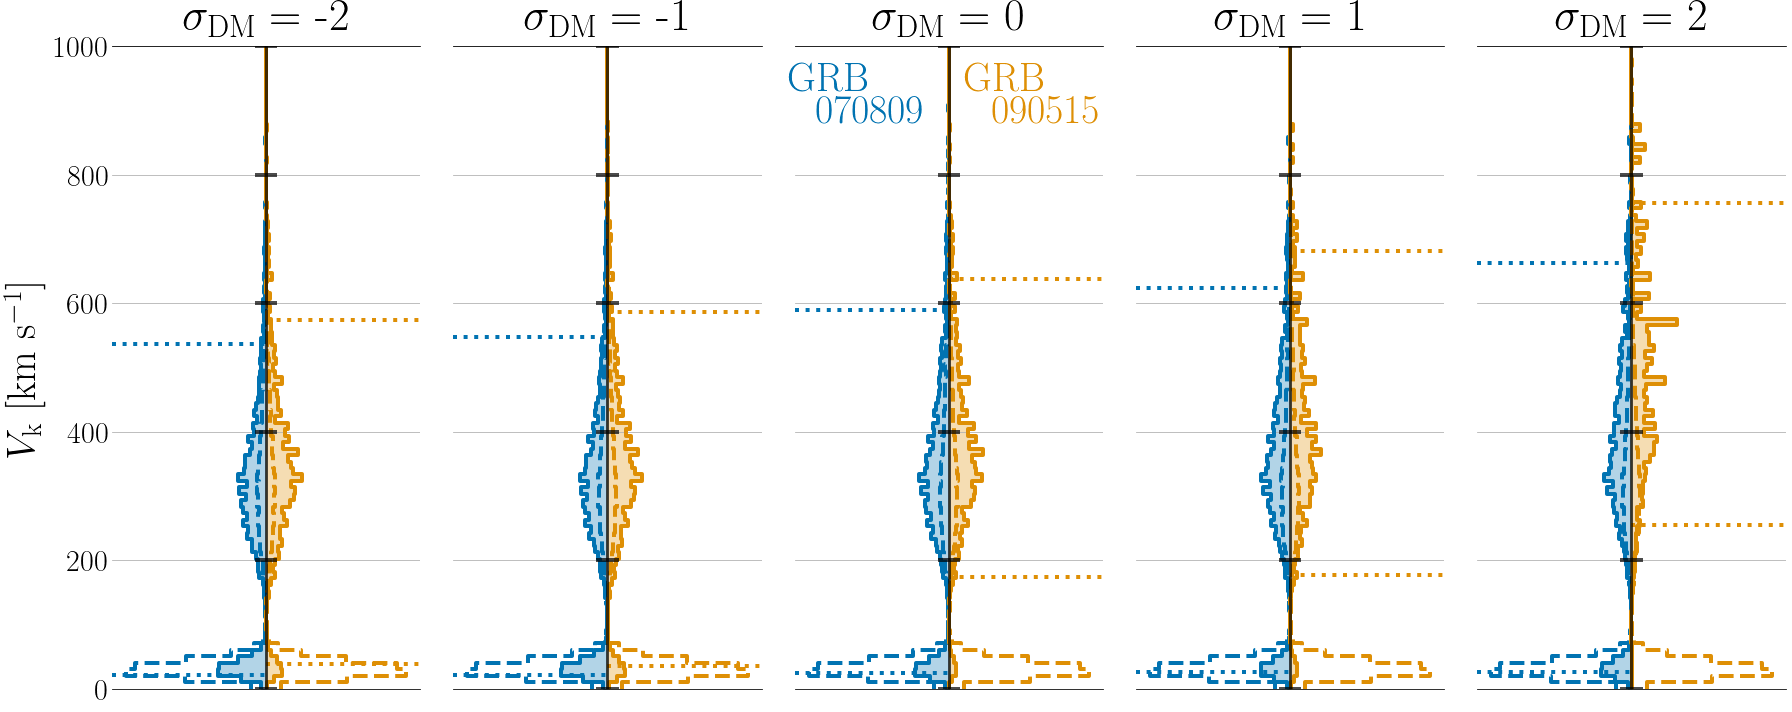

In [402]:
colors = sns.color_palette("colorblind")

violin_plot_DM(combined_popsynth_data, 'Vk', lbl_dict, param_range=(0,1000), logbins=False)

In [417]:
data['090515']['sigma0']['galaxy'].time_end - data['090515']['sigma0']['galaxy'].time_quench

<Quantity 3.60454545 Gyr>

In [300]:
from scipy.stats import norm
v200_070809 = np.asarray([0.7150506156519807,0.7274546648154194,0.7910439809038474,0.8211875907541746,0.8211875907541746])
v200_090515 = np.asarray([0.867138273144054,0.8633650890677534,0.9251876048341976,0.9340159035246274,0.9842621775621548])
p_normal = np.asarray([norm(0, 1).pdf(-2),norm(0, 1).pdf(-1),norm(0, 1).pdf(0),norm(0, 1).pdf(1),norm(0, 1).pdf(2)])

print('GRB 070809: {:0.4f}'.format(np.average(v200_070809, weights=p_normal)))
print('GRB 090515: {:0.4f}'.format(np.average(v200_090515, weights=p_normal)))

GRB 070809: 0.7804
GRB 090515: 0.9123


0.228742822611794
0.4243958767695881
0.2600179553714789
0.6853110032415105
0.25335266500325154
0.7544075129898793
0.20216766871528127
0.9364418785910406
0.1535168863601065
0.943373959893377


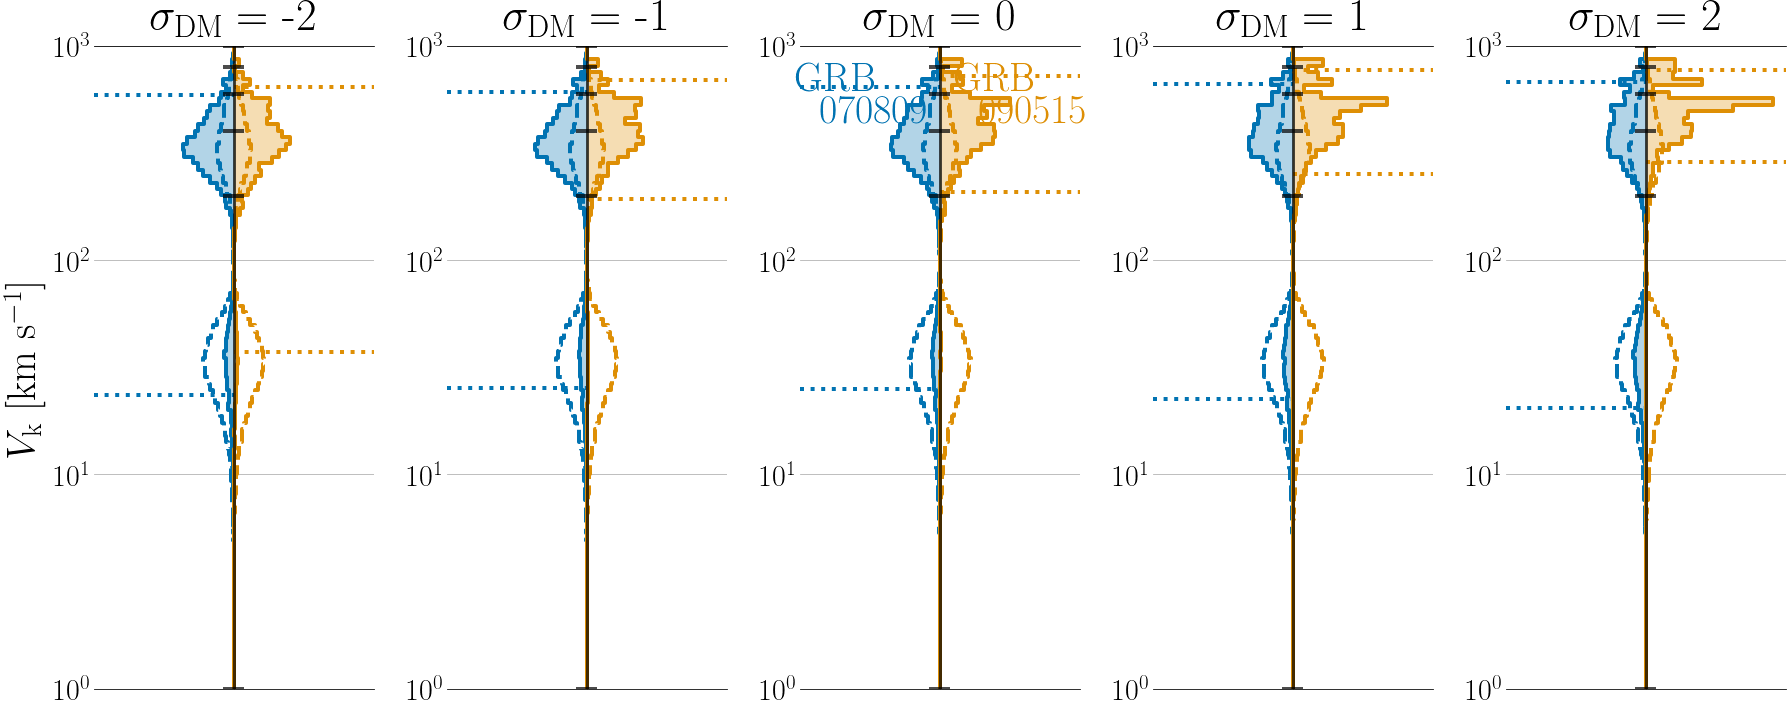

In [18]:
violin_plot_DM(combined_popsynth_data, 'Vk', lbl_dict, param_range=(1,1000), logbins=True)

#### Violin plot for each parameter indivually

In [380]:
def violin_plot_params(data, sigma, Nbins=100):
    Nparams = 3
    fig, axs = plt.subplots(1, Nparams, figsize=(5*Nparams,10))
    
    data['dM'] = data['Mpre']-data['Mpost']
    
    # Params: SNkick_2, m20-m2, a, Vsys_final, Tinsp
    params = ['Vk', 'dM', 'Apost', 'Vsys', 'Tinsp']
    labels = [r'$V_{\rm k}$ [km\,s$^{-1}$]', r'$\Delta M$ [M$_{\odot}$]', r'$A_{\rm pre}$ [R$_{\odot}$]', \
              r'$V_{\rm sys}$ [km\,s$^{-1}$]', r'$t_{\rm insp}$ [Gyr]']
    title_labels = [r'$V_{\rm k}$', r'$\Delta M$', r'$A_{\rm pre}$', r'$V_{\rm sys}$', r'$t_{\rm insp}$']
    ranges = [(0,1000), (0,8), (1e-1,1e2), (0,1000), (1e-4, 1e1)]
    ticks = [np.linspace(0,1000,6), np.linspace(0,8,9), np.logspace(-1,2,4), np.linspace(0,1000,6), np.logspace(-4,1,6)]
    
    # only 3 params
    params = ['dM', 'Apost', 'Tinsp']
    labels = [r'$\Delta M$ [M$_{\odot}$]', r'$A_{\rm pre}$ [R$_{\odot}$]', r'$t_{\rm insp}$ [Gyr]']
    title_labels = [r'$\Delta M$', r'$A_{\rm pre}$', r'$t_{\rm insp}$']
    ranges = [(0,4), (3e-1,1e2), (1e-4, 1.4e1)]
    ticks = [np.linspace(0,4,5), np.asarray([0.3,1,3,10,30,100]), np.logspace(-4,1,6)]

    
    for pidx, (param,label,title_label,prange,pticks) in enumerate(zip(params,labels,title_labels,ranges,ticks)):
        ax = axs[pidx]
        
        if param in ['Apost','Tinsp']:
            logbins=True
        else:
            logbins=False
        
        if logbins:
            bins = np.logspace(np.log10(prange[0]), np.log10(prange[1]), Nbins)
            ax.set_yscale('log')
        else:
            bins = np.linspace(prange[0], prange[1], Nbins)
            
        # format plot
        ax.set_xticklabels([])
        ax.set_ylabel(label)
        ax.set_ylim(prange)
        # remove grid and axeslines
        ax.grid(False)
        ax.grid(True, axis='y')
        if pidx==1:
            ax.set_yticks(pticks)
            ax.set_yticklabels(pticks)
        
        lw=4
        grbs = ['070809', '090515']
        for gidx, grb in enumerate(grbs):
            data_tmp = data.loc[(data['sigma'] == sigma) & (data['grb'] == grb)]
        
            # plot histograms
            h, _ = np.histogram(data_tmp[param], weights=None, bins=bins, range=(prange[0], prange[1]), density=True)
            h_weighted, _ = np.histogram(data_tmp[param], weights=data_tmp['weights'], bins=bins, range=(prange[0], prange[1]), density=True)
        
            low90 = wquantiles.quantile(data_tmp[param], data_tmp['weights'], 0.05)
            high90 = wquantiles.quantile(data_tmp[param], data_tmp['weights'], 0.95)
            
            if logbins:
                bin_widths = bins[1:]-bins[:-1]
                h = h*bin_widths
                h_weighted = h_weighted*bin_widths
                
            max_height = np.max([h.max(),h_weighted.max()])
            
            # do special scaling for Tinsp
            if param=='Tinsp':
                h = np.log10(h)+np.abs(np.log10(h).min())
                h_weighted[np.argwhere(h_weighted < 1e-8)] = 1e-8
                h_weighted = np.log10(h_weighted)+np.abs(np.log10(h_weighted).min())
                max_height = np.max([h.max(),h_weighted.max()])
            
            
            if gidx==0:
                ax.plot(-np.append(h,0), bins, drawstyle="steps", color=colors[0], lw=lw, linestyle='--')
                ax.plot(-np.append(h_weighted,0), bins, drawstyle="steps", color=colors[0], lw=lw, linestyle='-')
                ax.axhline(low90, xmin=0, xmax=0.5, color=colors[0], lw=lw, linestyle=':')
                ax.axhline(high90, xmin=0, xmax=0.5, color=colors[0], lw=lw, linestyle=':')
                ax.fill_betweenx(bins, -np.append(h_weighted,0), np.zeros(len(h_weighted)+1), step="post", color=colors[0], alpha=0.3)
                ax.hlines(pticks, xmin=-max_height/8, xmax=0, color='k', alpha=0.7, lw=3, zorder=30)
            elif gidx==1:
                ax.plot(np.append(h,0), bins, drawstyle="steps", color=colors[1], lw=lw, linestyle='--')
                ax.plot(np.append(h_weighted,0), bins, drawstyle="steps", color=colors[1], lw=lw, linestyle='-')
                ax.axhline(low90, xmin=0.5, xmax=1, color=colors[1], lw=lw, linestyle=':')
                ax.axhline(high90, xmin=0.5, xmax=1, color=colors[1], lw=lw, linestyle=':')
                ax.fill_betweenx(bins, np.zeros(len(h_weighted)+1), np.append(h_weighted,0), step="post", color=colors[1], alpha=0.3)
                ax.hlines(pticks, xmin=0, xmax=max_height/8, color='k', alpha=0.7, lw=3, zorder=30)
                
                        
        # create center line and center ticks
        ax.axvline(0, color='k', alpha=0.7)
        
    # set xlimits and labels
    axs[0].set_xlim(-2.8,2.8)
    axs[0].set_xticks([])
    axs[0].set_xlabel(r'$p(\Delta M / \mathrm{M}_\odot)$', labelpad=30)
    
    axs[1].set_xlim(-0.07,0.07)
    axs[1].set_xticks([])
    axs[1].set_xlabel(r'$p(\mathrm{log}_{10} [A_{\rm pre} / \mathrm{R}_\odot])$', labelpad=30)
    
    axs[2].set_xlim(-8,8)
    axs[2].set_xticks([])
    axs[2].set_xlabel(r'$p(\mathrm{log}_{10} [t_{\rm insp} / \mathrm{Gyr}])$', labelpad=30)

    plt.tight_layout(w_pad=3)
    plt.subplots_adjust(right=0.95)
    plt.savefig('/Users/michaelzevin/research/sgrb/paper_files/figures/pop_params.png', dpi=200)
    plt.savefig('/Users/michaelzevin/research/sgrb/paper_files/figures/pop_params.pdf', dpi=200)
    

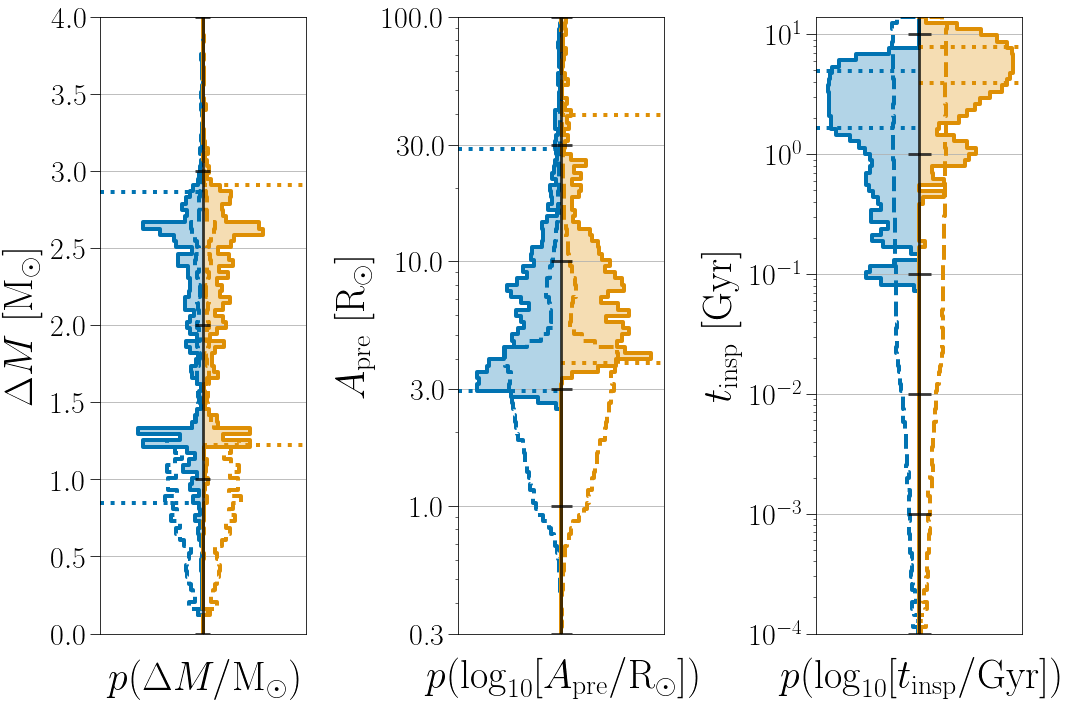

In [381]:
colors = sns.color_palette("colorblind")

violin_plot_params(combined_popsynth_data, 0)

In [45]:
violin_plot(combined_popsynth_data, 'a', lbl_dict, param_range=(0,10), logbins=False)

NameError: name 'violin_plot' is not defined

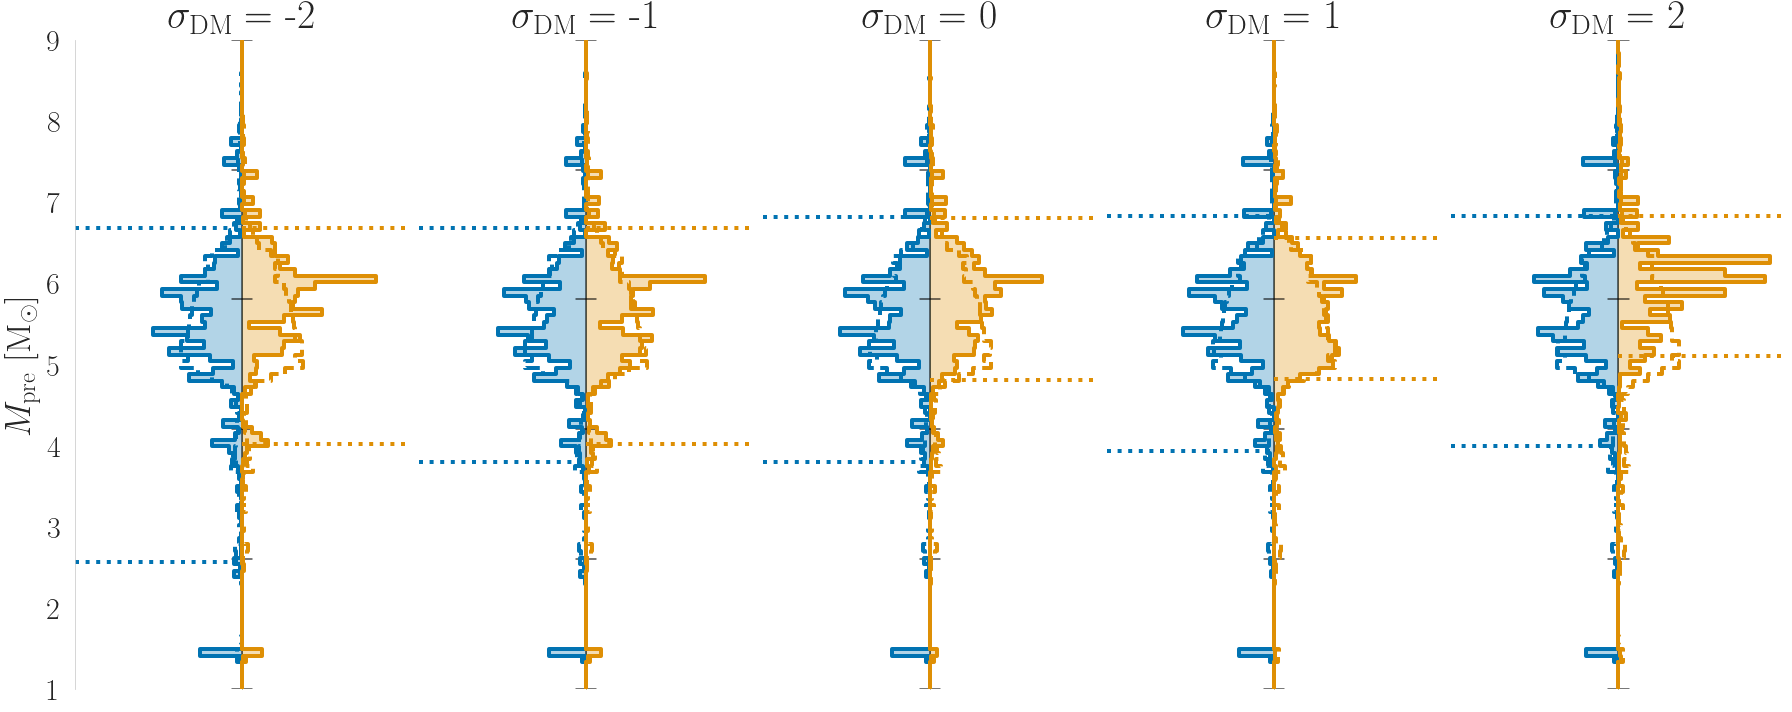

In [19]:
violin_plot(combined_popsynth_data, 'm20', lbl_dict, param_range=(1,9), logbins=False)

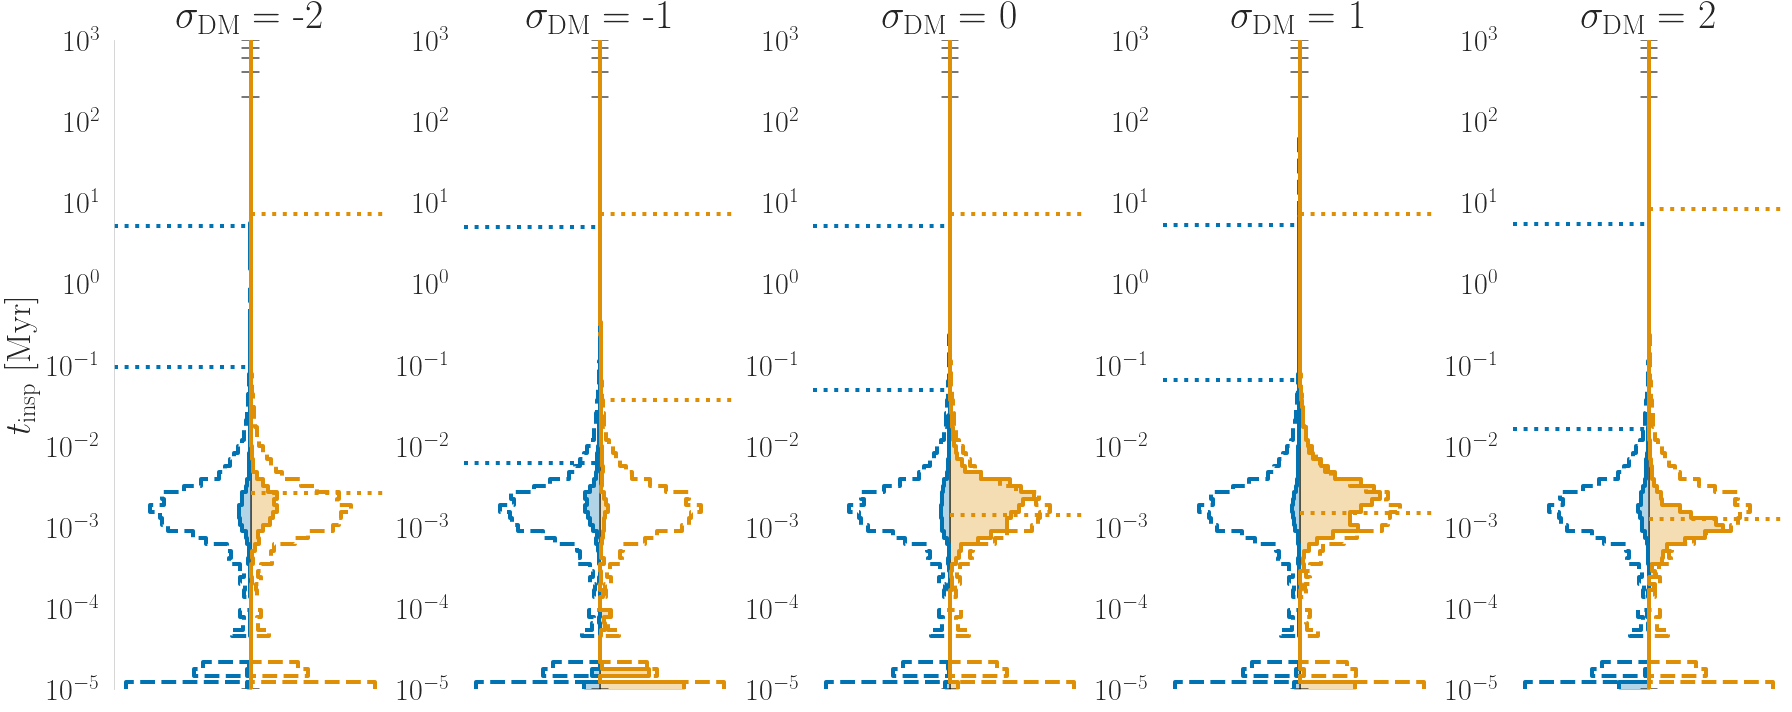

In [22]:
violin_plot(combined_popsynth_data, 'Tinsp', lbl_dict, param_range=(1e-5,1e3), logbins=True)